# Baseball Case Study


In this project, we will use machine learning models to predict Major-League Baseball team wins per season based on Lahman's Baseball data.

##importing the data
##cleaning and preparing the data
##exploring and visualizing the data
##adding new features
##adding one more feature using K-means clustering
##splitting dataset into train_set and test_set
##selecting error metric: mean absolute error vs mean squared error
##linear regression model
##ridge regression model
##conclusion

In [ ]:
# import `pandas` and `sqlite3`
import pandas as pd
import sqlite3

# Connecting to SQLite Database
conn = sqlite3.connect('lahman2016.sqlite')

In [6]:
# Querying Database for all seasons where a team played 150 or more games and is still active today. 
query = '''select * from Teams 
inner join TeamsFranchises
on Teams.franchID == TeamsFranchises.franchID
where Teams.G >= 150 and TeamsFranchises.active == 'Y';
'''

# Creating dataframe from query.
Teams = conn.execute(query).fetchall()

In [8]:
#convert 'Teams' to a dataframe using pandas library
teams_df = pd.DataFrame(Teams)
teams_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,1961,AL,LAA,ANA,None,8,162,82.0,70,91,...,603510,111,112,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
1,1962,AL,LAA,ANA,None,3,162,81.0,86,76,...,1144063,97,97,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
2,1963,AL,LAA,ANA,None,9,161,81.0,70,91,...,821015,94,94,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
3,1964,AL,LAA,ANA,None,5,162,81.0,82,80,...,760439,90,90,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
4,1965,AL,CAL,ANA,None,7,162,80.0,75,87,...,566727,97,98,CAL,CAL,CAL,ANA,Los Angeles Angels of Anaheim,Y,None


###### Cleaning and preparing the data


add column names to dataframe

In [9]:
cols = ['yearID','lgID','teamID','franchID','divID',
        'Rank','G','Ghome','W','L','DivWin','WCWin',
        'LgWin','WSWin','R','AB','H','2B','3B','HR',
        'BB','SO','SB','CS','HBP','SF','RA','ER','ERA',
        'CG','SHO','SV','IPouts','HA','HRA','BBA','SOA',
        'E','DP','FP','name','park','attendance','BPF',
        'PPF','teamIDBR','teamIDlahman45','teamIDretro',
        'franchID','franchName','active','NAassoc']
teams_df.columns = cols

In [10]:
print(teams_df.head(2))


   yearID lgID teamID  franchID divID  Rank    G  Ghome   W   L  ...  \
0    1961   AL    LAA       ANA  None     8  162   82.0  70  91  ...   
1    1962   AL    LAA       ANA  None     3  162   81.0  86  76  ...   

  attendance  BPF  PPF teamIDBR  teamIDlahman45  teamIDretro  franchID  \
0     603510  111  112      LAA             LAA          LAA       ANA   
1    1144063   97   97      LAA             LAA          LAA       ANA   

                      franchName  active  NAassoc  
0  Los Angeles Angels of Anaheim       Y     None  
1  Los Angeles Angels of Anaheim       Y     None  

[2 rows x 52 columns]


drop unnecessary column variables



In [12]:
drop_cols = ['lgID','franchID','divID','Rank','Ghome',
             'L','DivWin','WCWin','LgWin','WSWin','SF',
             'name','park','attendance','BPF','PPF',
             'teamIDBR','teamIDlahman45','teamIDretro',
             'franchID','franchName','active','NAassoc']
df = teams_df.drop(drop_cols,axis=1)

In [13]:
df.head(2)

,yearID,teamID,G,W,R,AB,H,2B,3B,HR,...,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP
0,1961,LAA,162,70,744,5424,1331,218,22,189,...,5,34,4314,1391,180,713,973,192,154.0,0.969
1,1962,LAA,162,86,718,5499,1377,232,35,137,...,15,47,4398,1412,118,616,858,175,153.0,0.972


check how many null values for each column



In [14]:
print(df.isnull().sum(axis=0).tolist())


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 419, 1777, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0]


It shows that we have 110 null values in the 'SO'(strike outs) column, 22 in the 'DP'(double play) column, 419 in the 'CS'(caught stealing) column and 1777 in the 'HBP'(hit by pitch) column.

Since columns 'SO' and 'DP' are important for predicting the wins, we will fill the null values in them by median. Also we will need to drop 'CS' and 'HBP' because they are not important for the target.

In [15]:
df = df.drop(['CS','HBP'],axis=1)


In [16]:

df['SO'] = df['SO'].fillna(df['SO'].median())
df['DP'] = df['DP'].fillna(df['DP'].median())

In [17]:
print(df.isnull().sum(axis=0).tolist())


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


##### Exploring and visualizing the data



In [18]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'histogram of wins')

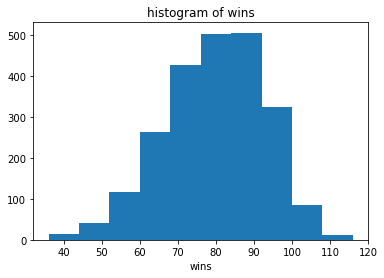

In [19]:
##visualize the histogram of wins
plt.hist(df['W'])
plt.xlabel('wins')
plt.title('histogram of wins')

In [20]:
##check out the average wins
df['W'].mean()


79.23043288150416

create win labels column for classification



In [21]:
#create bins for each win values
def assign_win_bins(w):
    if w < 50:
        return 1
    if w >= 50 and w <= 69:
        return 2
    if w >= 70 and w <= 89:
        return 3
    if w >= 90 and w <= 109:
        return 4
    if w >= 110:
        return 5

In [22]:

#apply to the 'W' column
df['win_bins'] = df['W'].apply(assign_win_bins)

visualize wins per year colored with win_bins



Text(0, 0.5, 'wins')

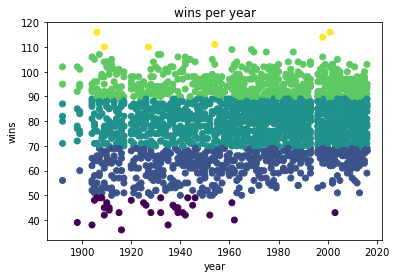

In [23]:
plt.scatter(df['yearID'],df['W'],c=df['win_bins'])
plt.title('wins per year')
plt.xlabel('year')
plt.ylabel('wins')

it seems we have much less data before 1900 than after, so it makes sense to drop them.



In [24]:
df = df[df['yearID']>1900]


integer values like yearID may cause problems. It is unlikely that year 1950 will have the same relationship to the rest of the data

Thus, we need to create new variables that label the data based on yearID

start by creating dictionaries runs_per_year and games_per_year

In [26]:

runs_per_year = {}
games_per_year = {}

for i, row in df.iterrows():
    year = row['yearID']
    runs = row['R']
    games = row['G']
    if year in runs_per_year:
        runs_per_year[year] = runs_per_year[year] + runs
        games_per_year[year] = games_per_year[year] + games
    else:
        runs_per_year[year] = runs
        games_per_year[year] = games

In [27]:
print(runs_per_year)


{1961: 12942, 1962: 14461, 1963: 12780, 1964: 13124, 1965: 12946, 1966: 12900, 1967: 12210, 1968: 11109, 1969: 15850, 1970: 16880, 1971: 15073, 1972: 13706, 1973: 16376, 1974: 16046, 1975: 16295, 1976: 15492, 1977: 18803, 1978: 17251, 1979: 18713, 1980: 18053, 1982: 18110, 1983: 18170, 1984: 17921, 1985: 18216, 1986: 18545, 1987: 19883, 1988: 17380, 1989: 17405, 1990: 17919, 1991: 18127, 1992: 17341, 1993: 20864, 1996: 22831, 1997: 21604, 1998: 23297, 1999: 24691, 2000: 24971, 2001: 23199, 2002: 22408, 2003: 22978, 2004: 23376, 2005: 22325, 2006: 23599, 2007: 23322, 2008: 22585, 2009: 22419, 2010: 21308, 2011: 20808, 2012: 21017, 2013: 20255, 2014: 19761, 2015: 20647, 2016: 21744, 1904: 9307, 1905: 9640, 1906: 8322, 1907: 8186, 1908: 8423, 1909: 8805, 1910: 9580, 1911: 11164, 1912: 11154, 1913: 9964, 1914: 9408, 1915: 9444, 1916: 8889, 1917: 8948, 1920: 10762, 1921: 11935, 1922: 12059, 1923: 11874, 1924: 11722, 1925: 12596, 1926: 11443, 1927: 11745, 1928: 11645, 1929: 12747, 1930: 1369

In [28]:
print(games_per_year)


{1961: 2860, 1962: 3242, 1963: 3238, 1964: 3252, 1965: 3246, 1966: 3230, 1967: 3240, 1968: 3250, 1969: 3892, 1970: 3888, 1971: 3876, 1972: 3718, 1973: 3886, 1974: 3890, 1975: 3868, 1976: 3878, 1977: 4206, 1978: 4204, 1979: 4198, 1980: 4210, 1982: 4214, 1983: 4218, 1984: 4210, 1985: 4206, 1986: 4206, 1987: 4210, 1988: 4200, 1989: 4212, 1990: 4210, 1991: 4208, 1992: 4212, 1993: 4538, 1996: 4534, 1997: 4532, 1998: 4864, 1999: 4856, 2000: 4858, 2001: 4858, 2002: 4852, 2003: 4860, 2004: 4856, 2005: 4862, 2006: 4858, 2007: 4862, 2008: 4856, 2009: 4860, 2010: 4860, 2011: 4858, 2012: 4860, 2013: 4862, 2014: 4860, 2015: 4858, 2016: 4856, 1904: 2498, 1905: 2474, 1906: 2307, 1907: 2317, 1908: 2488, 1909: 2482, 1910: 2498, 1911: 2474, 1912: 2464, 1913: 2468, 1914: 2512, 1915: 2490, 1916: 2494, 1917: 2494, 1920: 2468, 1921: 2458, 1922: 2476, 1923: 2466, 1924: 2462, 1925: 2456, 1926: 2468, 1927: 2472, 1928: 2462, 1929: 2458, 1930: 2468, 1931: 2472, 1932: 2466, 1933: 2303, 1934: 2297, 1935: 2158, 193

 mlb_runs_per_game dictionary with years as keys and number of runs per game as value



In [30]:
mlb_runs_per_game = {}

for k,v in games_per_year.items():
    year = k
    games = v
    runs = runs_per_year[year]
    mlb_runs_per_game[year] = runs/games

In [31]:
print(mlb_runs_per_game)


{1961: 4.525174825174825, 1962: 4.460518198642813, 1963: 3.9468807906114884, 1964: 4.035670356703567, 1965: 3.9882932840418976, 1966: 3.9938080495356036, 1967: 3.7685185185185186, 1968: 3.4181538461538463, 1969: 4.07245632065776, 1970: 4.341563786008231, 1971: 3.8888028895768834, 1972: 3.6863905325443787, 1973: 4.214101904271745, 1974: 4.124935732647815, 1975: 4.21277145811789, 1976: 3.99484270242393, 1977: 4.470518307180218, 1978: 4.103472882968601, 1979: 4.457598856598381, 1980: 4.2881235154394295, 1982: 4.297579496915045, 1983: 4.307728781412992, 1984: 4.256769596199525, 1985: 4.330955777460771, 1986: 4.409177365668093, 1987: 4.722802850356294, 1988: 4.1380952380952385, 1989: 4.132241215574549, 1990: 4.256294536817102, 1991: 4.307747148288973, 1992: 4.1170465337132, 1993: 4.597620096959012, 1996: 5.0355094838994265, 1997: 4.766990291262136, 1998: 4.789679276315789, 1999: 5.0846375617792425, 2000: 5.140181144503911, 2001: 4.7754219843557015, 2002: 4.6183017312448476, 2003: 4.72798353

visualize yearly MLB runs per game



In [32]:
#create lists from mlb_runs_per_game dictionary
lists = sorted(mlb_runs_per_game.items())
x,y = zip(*lists)
#x is the list of keys, y is the list of values

Text(0, 0.5, 'mlb runs per game')

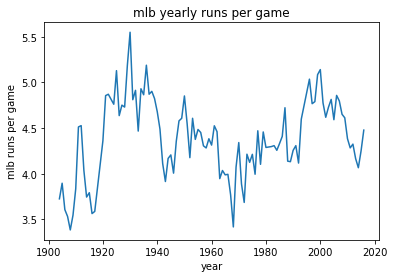

In [33]:
#create line plot of mlb_runs_per_game vs year
plt.plot(x,y)
plt.title('mlb yearly runs per game')
plt.xlabel('year')
plt.ylabel('mlb runs per game')

#### Adding new features



Based on the trend of mlb runs, we can create a new variable 'year_label' that indicate era.



In [34]:
def assign_label(year):
    if year < 1920:
        return 1
    elif year >= 1920 and year <= 1941:
        return 2
    elif year >= 1942 and year <= 1945:
        return 3
    elif year >= 1946 and year <= 1962:
        return 4
    elif year >= 1963 and year <= 1976:
        return 5
    elif year >= 1977 and year <= 1992:
        return 6
    elif year >= 1993 and year <= 2009:
        return 7
    elif year >= 2010:
        return 8

In [35]:
df['year_label'] = df['yearID'].apply(assign_label)


create dummy variables for 'year_label'



In [36]:
dummy_df = pd.get_dummies(df['year_label'],prefix='era')


In [37]:
dummy_df.head()


,era_1,era_2,era_3,era_4,era_5,era_6,era_7,era_8
0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0


In [38]:
df = pd.concat([df,dummy_df],axis=1)


In [39]:
df.head(2)


,yearID,teamID,G,W,R,AB,H,2B,3B,HR,...,win_bins,year_label,era_1,era_2,era_3,era_4,era_5,era_6,era_7,era_8
0,1961,LAA,162,70,744,5424,1331,218,22,189,...,3,4,0,0,0,1,0,0,0,0
1,1962,LAA,162,86,718,5499,1377,232,35,137,...,3,4,0,0,0,1,0,0,0,0


create column for mlb_runs_per_game



In [40]:
def assign_mlb_rpg(year):
    return mlb_runs_per_game[year]
df['mlb_rpg'] = df['yearID'].apply(assign_mlb_rpg)

convert years into decades



In [41]:
def assign_decade(year):
    if year < 1920:
        return 1910
    elif year >= 1920 and year <= 1929:
        return 1920
    elif year >= 1930 and year <= 1939:
        return 1930
    elif year >= 1940 and year <= 1949:
        return 1940
    elif year >= 1950 and year <= 1959:
        return 1950
    elif year >= 1960 and year <= 1969:
        return 1960
    elif year >= 1970 and year <= 1979:
        return 1970
    elif year >= 1980 and year <= 1989:
        return 1980
    elif year >= 1990 and year <= 1999:
        return 1990
    elif year >= 2000 and year <= 2009:
        return 2000
    elif year >= 2010:
        return 2010

In [42]:
df['decade_label'] = df['yearID'].apply(assign_decade)


In [43]:
decade_df = pd.get_dummies(df['decade_label'],prefix='decade')
decade_df.head()

,decade_1910,decade_1920,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010
0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0


In [44]:
df = pd.concat([df,decade_df],axis=1)



drop unnecessary columns



In [45]:
df = df.drop(['yearID','year_label','decade_label'],axis=1)


Adding two more features to increase the prediction of the model: runs_per_game and runs_allowed_per_game



In [46]:

df['R_per_game'] = df['R']/df['G']
df['RA_per_game'] = df['RA']/df['G']

Now we need to check how these two variables relate to our target 'W' column



Text(0.5, 0, 'runs allowed per game')

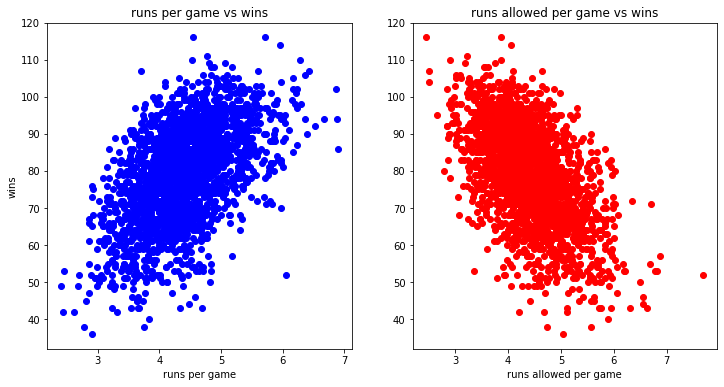

In [47]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(df['R_per_game'],df['W'],c='blue')
ax1.set_title('runs per game vs wins')
ax1.set_ylabel('wins')
ax1.set_xlabel('runs per game')

ax2.scatter(df['RA_per_game'],df['W'],c='red')
ax2.set_title('runs allowed per game vs wins')
ax2.set_xlabel('runs allowed per game')

visualize correlation between each of the variables and the target variable



In [48]:
df.corr()['W']


G              0.178958
W              1.000000
R              0.551504
AB             0.233996
H              0.380281
2B             0.262323
3B             0.016970
HR             0.312713
BB             0.345348
SO             0.072069
SB             0.133300
RA            -0.518313
ER            -0.372580
ERA           -0.425833
CG            -0.041788
SHO            0.426892
SV             0.382174
IPouts         0.326087
HA            -0.384893
HRA            0.009880
BBA           -0.284782
SOA            0.259205
E             -0.304725
DP             0.015192
FP             0.319597
win_bins       0.912545
era_1         -0.077104
era_2         -0.083089
era_3         -0.033073
era_4         -0.052278
era_5          0.042122
era_6          0.058439
era_7          0.066049
era_8          0.043453
mlb_rpg        0.006909
decade_1910   -0.077104
decade_1920   -0.055176
decade_1930   -0.052358
decade_1940   -0.050249
decade_1950   -0.047499
decade_1960    0.028594
decade_1970    0

#### Adding one more feature using K-means clustering



create the dataframe that leaves out the target column



In [49]:

attributes = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA','ER','ERA','CG',
'SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','era_1','era_2','era_3','era_4','era_5','era_6','era_7','era_8','decade_1910','decade_1920','decade_1930','decade_1940','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000','decade_2010','R_per_game','RA_per_game','mlb_rpg']

In [50]:
data_attributes = df[attributes]


In [51]:
df.head()


,teamID,G,W,R,AB,H,2B,3B,HR,BB,...,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,R_per_game,RA_per_game
0,LAA,162,70,744,5424,1331,218,22,189,681,...,0,0,1,0,0,0,0,0,4.592593,4.839506
1,LAA,162,86,718,5499,1377,232,35,137,602,...,0,0,1,0,0,0,0,0,4.432099,4.358025
2,LAA,161,70,597,5506,1378,208,38,95,448,...,0,0,1,0,0,0,0,0,3.708075,4.099379
3,LAA,162,82,544,5362,1297,186,27,102,472,...,0,0,1,0,0,0,0,0,3.358025,3.401235
4,CAL,162,75,527,5354,1279,200,36,92,443,...,0,0,1,0,0,0,0,0,3.253086,3.512346


using sklearn’s silhouette_score() to select the number of clusters. The best value of this function return is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

We want to have a high silhouette score, the score decreases as more cluster added



In [53]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [54]:
score_dict = {}
for i in range(2,11):
    km = KMeans(n_clusters = i, random_state=1)
    l = km.fit_predict(data_attributes)
    score = metrics.silhouette_score(data_attributes,l)
    score_dict[i] = score

In [55]:
score_dict


{2: 0.3906998802293878,
 3: 0.33807585484810926,
 4: 0.25351952557570395,
 5: 0.23561577404187492,
 6: 0.2138869412081822,
 7: 0.19570350588885863,
 8: 0.1866085747852742,
 9: 0.1735454878870926,
 10: 0.16986446409819547}

select 6 as the cluster_size. We create K-means model and visualize



In [56]:
kmeans_model = KMeans(n_clusters = 6, random_state=1)


In [57]:
#determine euclidian distances for each data points
distances = kmeans_model.fit_transform(data_attributes)

In [58]:
distances

array([[ 403.64157318,  905.96921371,  418.08948195,  691.28217379,
         881.91035476,  364.27867505],
       [ 176.63291442,  724.86201359,  462.79421258,  528.17076064,
         742.53312859,  356.92059367],
       [ 175.28064133,  760.02048493,  461.22878542,  533.34938643,
         670.03986589,  459.28750389],
       ...,
       [ 645.94940211, 1281.77528634,  315.40745596, 1063.25746178,
        1095.60371693,  628.81413485],
       [ 692.85283233, 1299.34088523,  309.93820869, 1072.79831862,
        1111.7177554 ,  628.41580125],
       [ 738.16587506, 1365.13388024,  349.40577985, 1136.23398531,
        1200.02051407,  665.81041136]])

Text(0.5, 1.0, 'kmeans clusters')

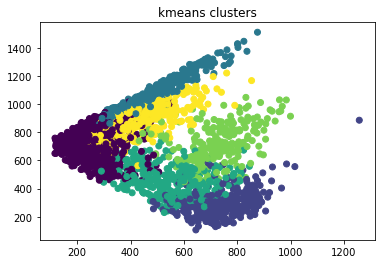

In [59]:
#create scatter plot colored by kmeans clusters
labels = kmeans_model.labels_
plt.scatter(distances[:,0],distances[:,1],c=labels)
plt.title('kmeans clusters')

add labels from the clusters as a new column to the dataset



In [60]:
df['labels'] = labels
attributes.append('labels')
df.head()

,teamID,G,W,R,AB,H,2B,3B,HR,BB,...,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,R_per_game,RA_per_game,labels
0,LAA,162,70,744,5424,1331,218,22,189,681,...,0,1,0,0,0,0,0,4.592593,4.839506,5
1,LAA,162,86,718,5499,1377,232,35,137,602,...,0,1,0,0,0,0,0,4.432099,4.358025,0
2,LAA,161,70,597,5506,1378,208,38,95,448,...,0,1,0,0,0,0,0,3.708075,4.099379,0
3,LAA,162,82,544,5362,1297,186,27,102,472,...,0,1,0,0,0,0,0,3.358025,3.401235,0
4,CAL,162,75,527,5354,1279,200,36,92,443,...,0,1,0,0,0,0,0,3.253086,3.512346,0


##### Spliting dataset into train_set and test_set



create a new dataframe includes only numeric columns



In [61]:
numeric_cols = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA','ER','ERA','CG','SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','era_1','era_2','era_3','era_4','era_5','era_6','era_7','era_8','decade_1910','decade_1920','decade_1930','decade_1940','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000','decade_2010','R_per_game','RA_per_game','mlb_rpg','labels','W']

In [62]:
data = df[numeric_cols]


In [63]:
data.head()


,G,R,AB,H,2B,3B,HR,BB,SO,SB,...,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,R_per_game,RA_per_game,mlb_rpg,labels,W
0,162,744,5424,1331,218,22,189,681,1068.0,37,...,0,0,0,0,0,4.592593,4.839506,4.525175,5,70
1,162,718,5499,1377,232,35,137,602,917.0,46,...,0,0,0,0,0,4.432099,4.358025,4.460518,0,86
2,161,597,5506,1378,208,38,95,448,916.0,43,...,0,0,0,0,0,3.708075,4.099379,3.946881,0,70
3,162,544,5362,1297,186,27,102,472,920.0,49,...,0,0,0,0,0,3.358025,3.401235,4.035670,0,82
4,162,527,5354,1279,200,36,92,443,973.0,107,...,0,0,0,0,0,3.253086,3.512346,3.988293,0,75


split data into train and test sets



In [64]:
train = data.sample(frac = 0.75, random_state=1)
test = data.loc[~data.index.isin(train.index)]

In [65]:

x_train = train[attributes]
y_train = train['W']
x_test = test[attributes]
y_test = test['W']

##### Selecting error metric: mean absolute error vs mean squared error



We use mean absolute error(MAE) as the error metric. MAE measures the absolute value that my prediction misses the true value.

###### Linear regression model



In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

create linear regression model, fit it and make predictions



In [67]:
lr = LinearRegression(normalize=True)


In [68]:
lr.fit(x_train,y_train)


LinearRegression(normalize=True)

In [69]:
predictions = lr.predict(x_test)


In [71]:
mae = mean_absolute_error(y_test,predictions)


In [72]:
mae

2.68879022899592

Now we recall that the average number of wins is about 79 wins. On average, the model is off by about 2.687 wins.



##### Ridge regression model



In [73]:
from sklearn.linear_model import RidgeCV


In [74]:
rrm = RidgeCV(alphas=(0.01,0.1,1,10),normalize=True)


In [75]:
rrm.fit(x_train,y_train)


RidgeCV(alphas=array([ 0.01,  0.1 ,  1.  , 10.  ]), normalize=True)

In [76]:
predictions = rrm.predict(x_test)


In [77]:

mae_rrm = mean_absolute_error(y_test,predictions)
mae_rrm

2.6725918746464394

So Ridge regression model is slightly better than Linear regression model because it has less mean absolute error.



###### Conclusion

We imported data from SQLite database, cleaned it, explored it to visualize, engineered some new features. Then, we applied K-means clustering model, linear regression model and ridge regression model to predict wins. Finally, we used mean absolute error to evaluate these models.

# Avacado Project


Avocado is a fruit consumed by people heavily in the United States.

This data was downloaded from the Hass Avocado Board website in May of 2018 & compiled into a single CSV.

The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados.

Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags.

The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

Some relevant columns in the dataset:

Date - The date of the observation
AveragePrice - the average price of a single avocado
type - conventional or organic
year - the year
Region - the city or region of the observation
Total Volume - Total number of avocados sold
4046 - Total number of avocados with PLU 4046 sold
4225 - Total number of avocados with PLU 4225 sold
4770 - Total number of avocados with PLU 4770 sold

Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt              #for plotting and EDA
import seaborn as sns                        #for plotting and Eda
from sklearn.model_selection import train_test_split         #for splitting dataset into train and test
from sklearn.metrics import r2_score                         #for model evaluation
from sklearn.metrics import mean_squared_error               #for model evaluation
from sklearn.metrics import mean_absolute_error              #for checking model accuracy
from sklearn.linear_model import LinearRegression            #regression model
from sklearn.tree import DecisionTreeRegressor               #regression model
from sklearn.ensemble import RandomForestRegressor           #regression model
from sklearn.model_selection import cross_val_score          #for cross validating model
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Avocado.csv')
df = pd.DataFrame(data = df)

In [3]:
df.head(20)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,27-12-2015,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,20-12-2015,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,13-12-2015,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,06-12-2015,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,29-11-2015,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
5,5,22-11-2015,1.26,55979.78,1184.27,48067.99,43.61,6683.91,6556.47,127.44,0.0,conventional,2015,Albany
6,6,15-11-2015,0.99,83453.76,1368.92,73672.72,93.26,8318.86,8196.81,122.05,0.0,conventional,2015,Albany
7,7,08-11-2015,0.98,109428.33,703.75,101815.36,80.00,6829.22,6266.85,562.37,0.0,conventional,2015,Albany
8,8,01-11-2015,1.02,99811.42,1022.15,87315.57,85.34,11388.36,11104.53,283.83,0.0,conventional,2015,Albany
9,9,25-10-2015,1.07,74338.76,842.40,64757.44,113.00,8625.92,8061.47,564.45,0.0,conventional,2015,Albany


In [4]:
df.shape


(1517, 14)

In [5]:
df.dtypes


Unnamed: 0        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
dtype: object

Date, region, type are object type while year is int64. All the other columns are of float64 data type.



In [6]:
df.apply(lambda x: len(x.unique()))


Unnamed: 0        52
Date             104
AveragePrice     113
Total Volume    1517
4046            1517
4225            1517
4770            1516
Total Bags      1517
Small Bags      1517
Large Bags      1377
XLarge Bags      711
type               1
year               2
region            51
dtype: int64

The dataset only has 1 unique value for type column so we can drop that column from the dataset.



In [7]:
df.drop('type', axis = 1, inplace = True)


Checking and dealing missing values¶


In [8]:
df.isnull().sum()


Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
year            0
region          0
dtype: int64

No null values present in the dataset

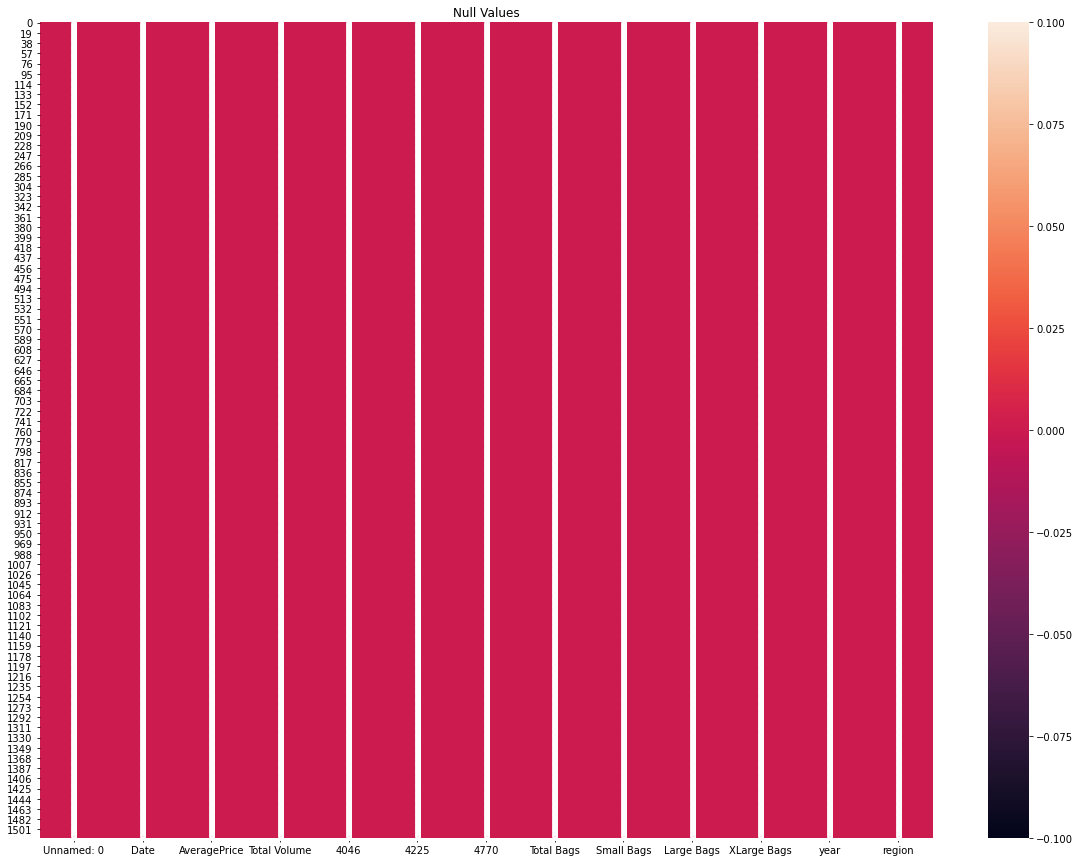

In [9]:
plt.figure(figsize = [20, 15])
sns.heatmap(df.isnull(), annot = True)                           #Visual representation of no null values present in dataset
plt.title('Null Values')
plt.show()

In [10]:
df['Month'] = df['Date'].apply(lambda x: x[3:5])
df['Month'] = df['Month'].astype(float)

We created a new column 'Month' from the date column.



In [11]:
df.dtypes


Unnamed: 0        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
year              int64
region           object
Month           float64
dtype: object

In [12]:
df.drop('Date', axis = 1, inplace = True)


In [13]:
df.head(10)


,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,region,Month
0,0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,2015,Albany,12.0
1,1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,2015,Albany,12.0
2,2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,2015,Albany,12.0
3,3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,2015,Albany,12.0
4,4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,2015,Albany,11.0
5,5,1.26,55979.78,1184.27,48067.99,43.61,6683.91,6556.47,127.44,0.0,2015,Albany,11.0
6,6,0.99,83453.76,1368.92,73672.72,93.26,8318.86,8196.81,122.05,0.0,2015,Albany,11.0
7,7,0.98,109428.33,703.75,101815.36,80.00,6829.22,6266.85,562.37,0.0,2015,Albany,11.0
8,8,1.02,99811.42,1022.15,87315.57,85.34,11388.36,11104.53,283.83,0.0,2015,Albany,11.0
9,9,1.07,74338.76,842.40,64757.44,113.00,8625.92,8061.47,564.45,0.0,2015,Albany,10.0


In [14]:
df.describe()  #Describing the dataset


,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,Month
count,1517.000000,1517.000000,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1517.000000,1517.000000,1517.000000
mean,26.995386,1.074990,1.601879e+06,6.464387e+05,6.114375e+05,5.040550e+04,2.935974e+05,2.487736e+05,4.264205e+04,2181.771074,2015.162821,6.166777
std,14.848287,0.188891,4.433143e+06,1.947614e+06,1.672906e+06,1.377812e+05,7.579765e+05,6.474765e+05,1.182157e+05,7455.712144,0.369324,3.391243
min,0.000000,0.490000,3.875074e+04,4.677200e+02,1.783770e+03,0.000000e+00,3.311770e+03,3.311770e+03,0.000000e+00,0.000000,2015.000000,1.000000
25%,14.000000,0.980000,1.474700e+05,2.040034e+04,4.147606e+04,9.112500e+02,3.620689e+04,2.972722e+04,5.407400e+02,0.000000,2015.000000,3.000000
50%,29.000000,1.080000,4.027919e+05,8.175117e+04,1.186649e+05,7.688170e+03,7.397906e+04,6.237569e+04,5.044350e+03,0.000000,2015.000000,6.000000
75%,39.000000,1.190000,9.819751e+05,3.775785e+05,4.851503e+05,2.916730e+04,1.576097e+05,1.461994e+05,2.926767e+04,401.480000,2015.000000,9.000000
max,51.000000,1.680000,4.465546e+07,1.893304e+07,1.895648e+07,1.381516e+06,6.736304e+06,5.893642e+06,1.121076e+06,108072.790000,2016.000000,12.000000


The mean of AveragePrice is 1.07 and the mode is 1.08. The range of AveragePrice is 0.49 - 1.68 and IQR is 0.98 - 1.19.

The mean of Total Volume is 1601879 and the mode is 4027919. The range of Total Volume is 38750.74 - 44655460+ and IQR is 147470 - 981975.

The mean of 4046 is 646438.7 and the mode is 81751.17. The range of 4046 is 467.72 - 18933040+ and IQR is 20400.34 - 377578.5.

The mean of 4225 is 611437.5 and the mode is 118664.9. The range of 4225 is 1783.77 - 18956480+ and IQR is 41476.06 - 485150.3.

The mean of 4770 is 50405.50 and the mode is 7688.17. The range of 4770 is 0 - 1381516 and IQR is 911.25 - 29167.30.

The mean of Total Bags is 293597 and the mode is 73979.06. The range of Total Bags is 3311.77 - 6736304 and IQR is 36206.89 - 157609.7.

The mean of Small Bags is 248773.6 and the mode is 62375.69. The range of Small Bags is 3311.77 - 5893642 and IQR is 29727.22 - 146199.4.

The mean of Large Bags is 42642.05 and the mode is 5044.35. The range of Large Bags is 0 - 1121076 and IQR is 540.74 - 29267.67.

The mean of XLarge Bags is 2181.77 and the mode is 0. The range of XLarge Bags is 0 - 108072.79 and IQR is 0 - 401.48.

# EDA and Data Visualisation

In [15]:

cont_cols = ['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
cate_cols = ['year', 'region', 'Month']

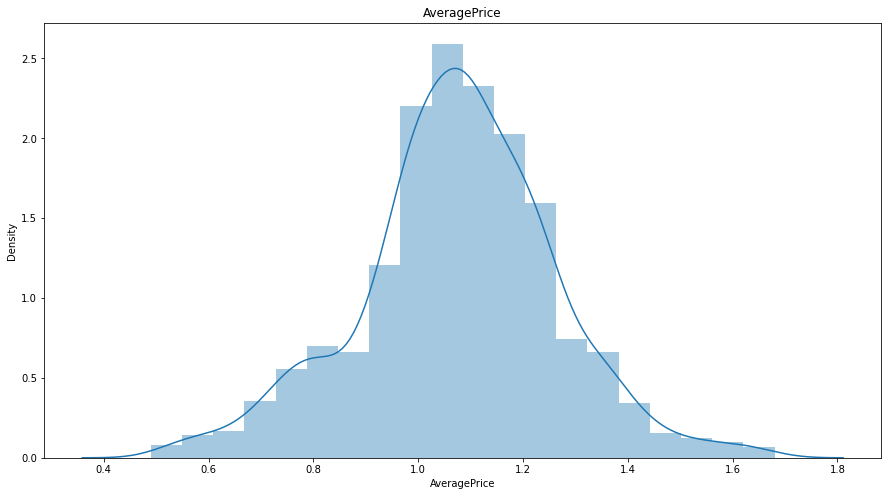

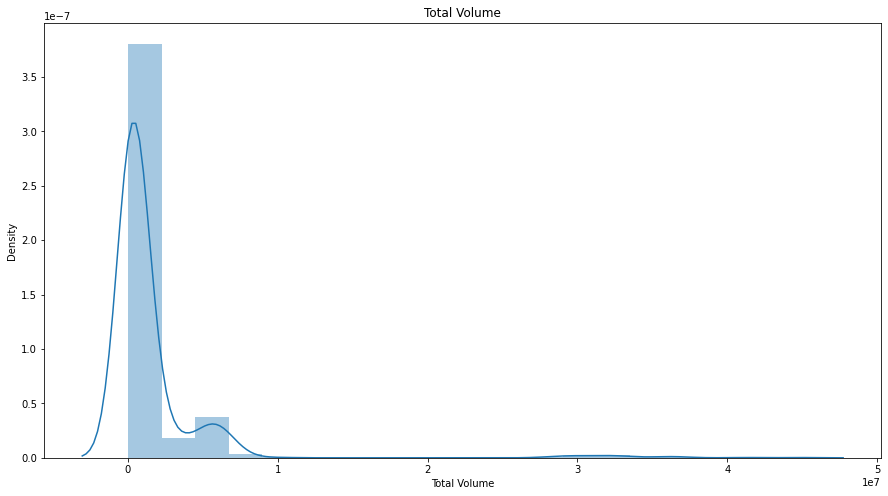

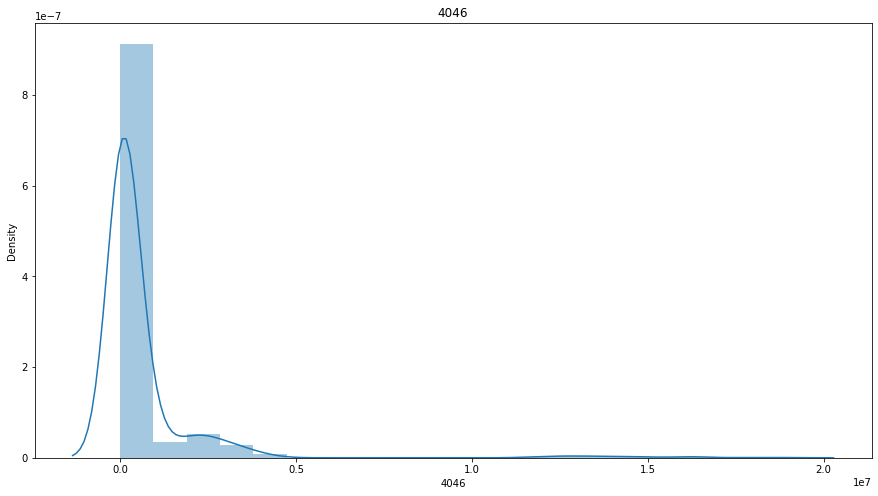

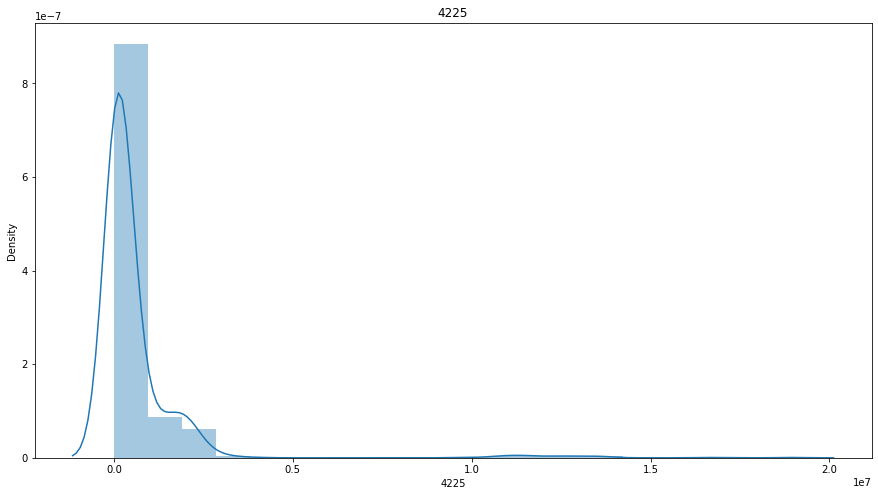

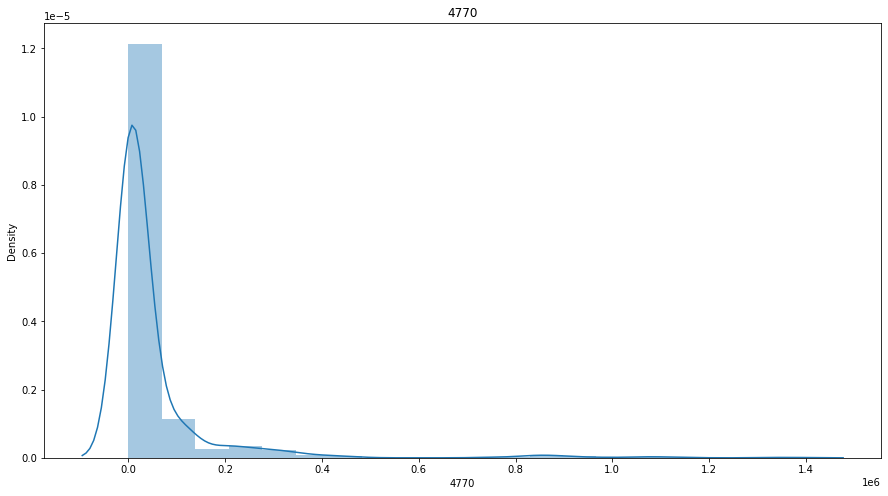

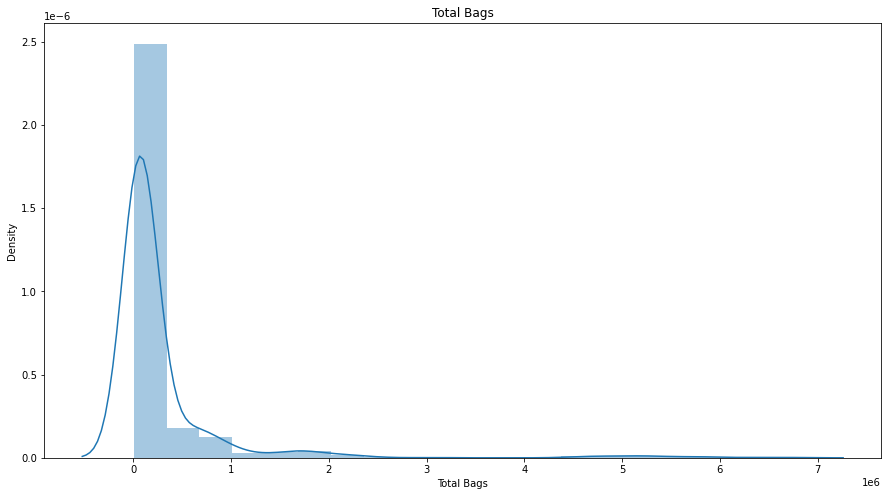

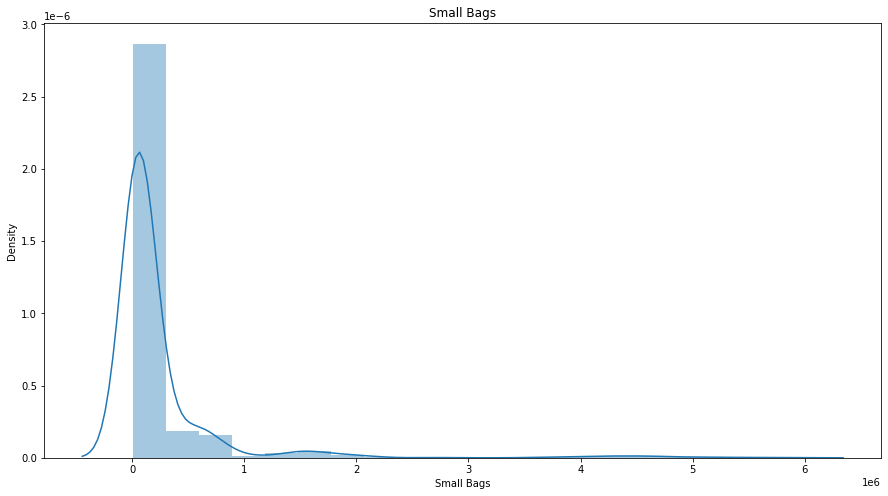

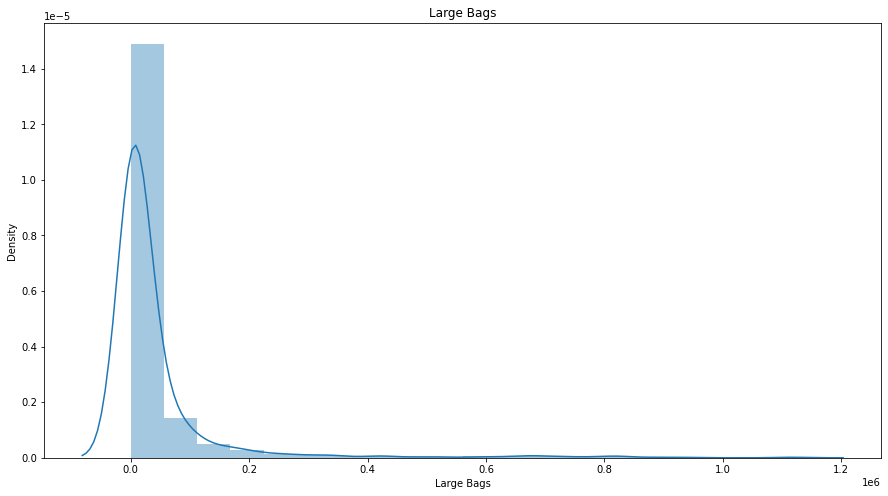

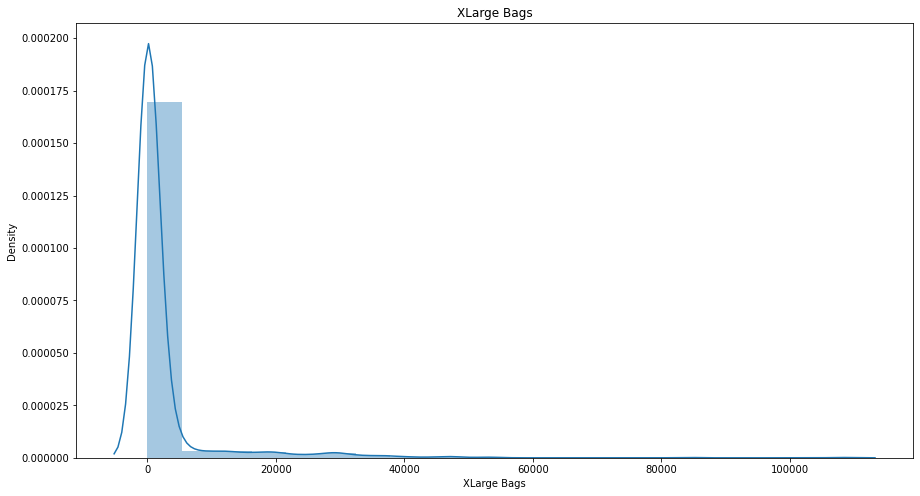

In [16]:
for i in df[cont_cols]:                                 #univariate analysis
    plt.figure(figsize = (15, 8))
    sns.distplot(df[i], bins = 20)
    plt.title(i)
    plt.show()

Average sales has the perfect bell shaped graph, while other graphs are more centered towards 0 and shows right tail skewness.



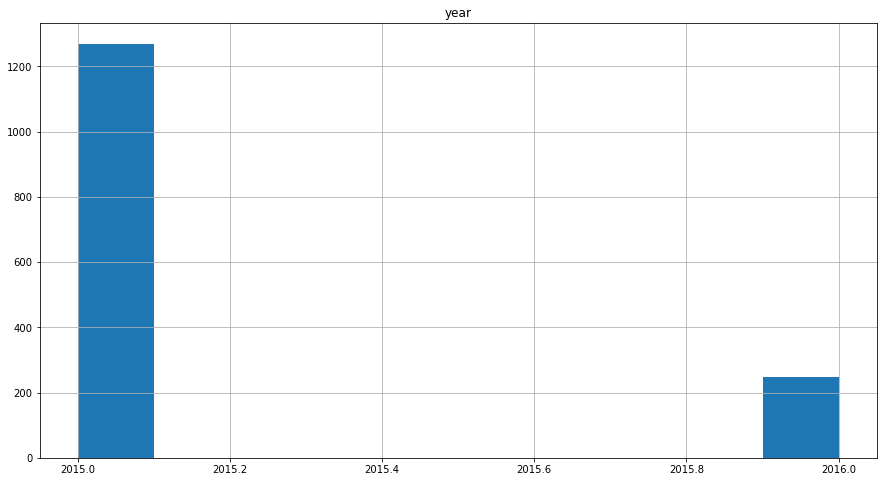

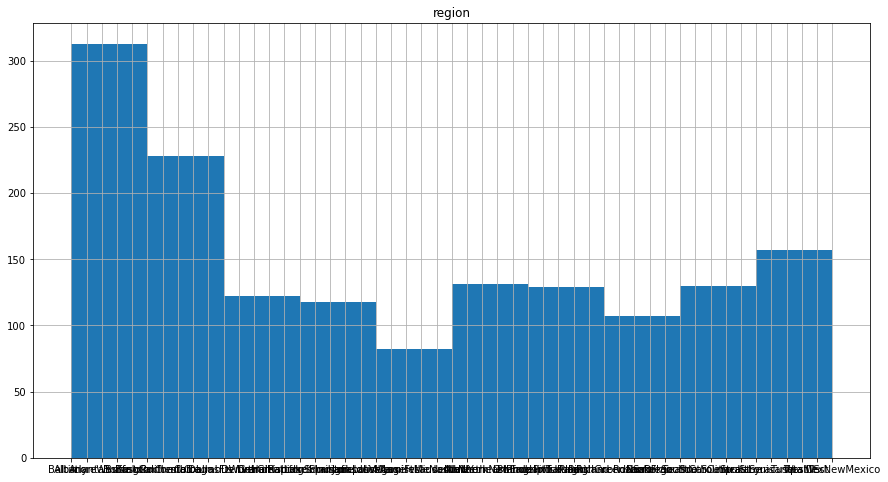

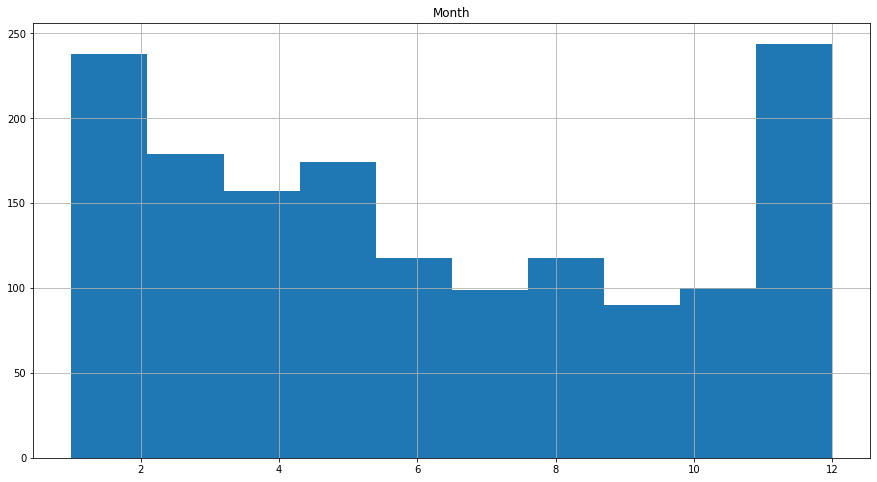

In [17]:
for i in cate_cols:
    plt.figure(figsize = (15, 8))
    df[i].hist(grid = True)
    plt.title(i)
    plt.show()

Most of the data is taken in 2015 and is acquiered in the month of December and January.



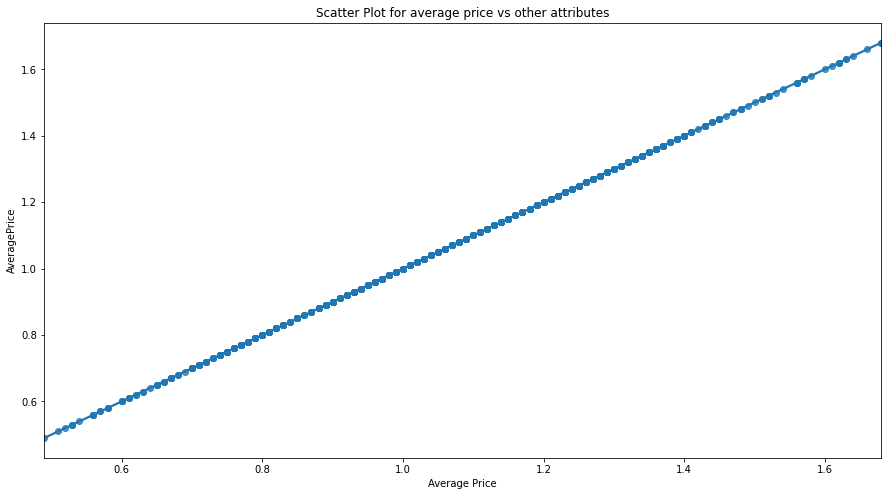

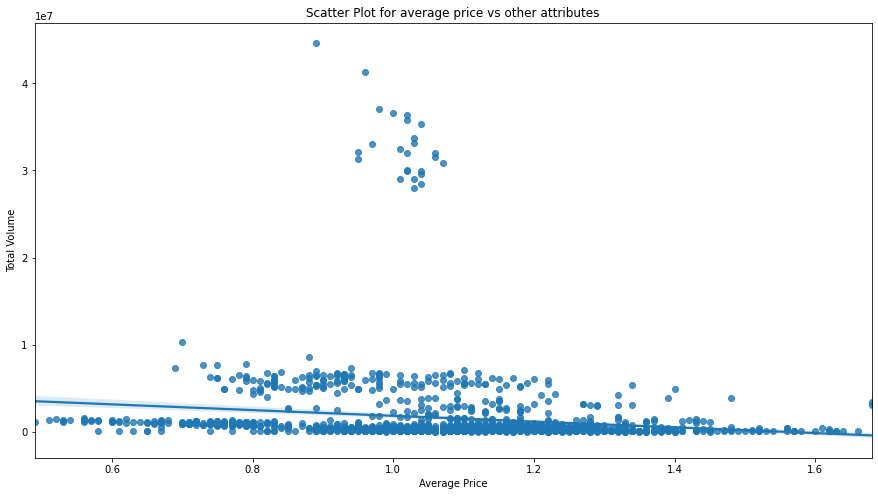

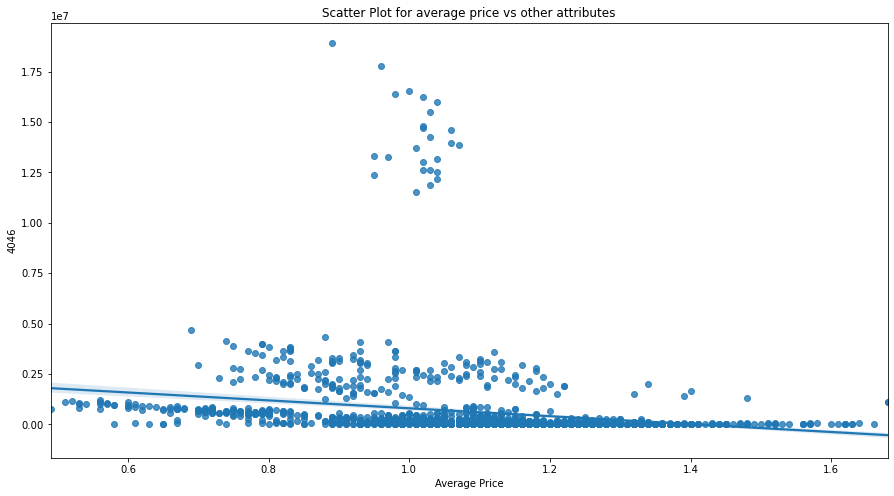

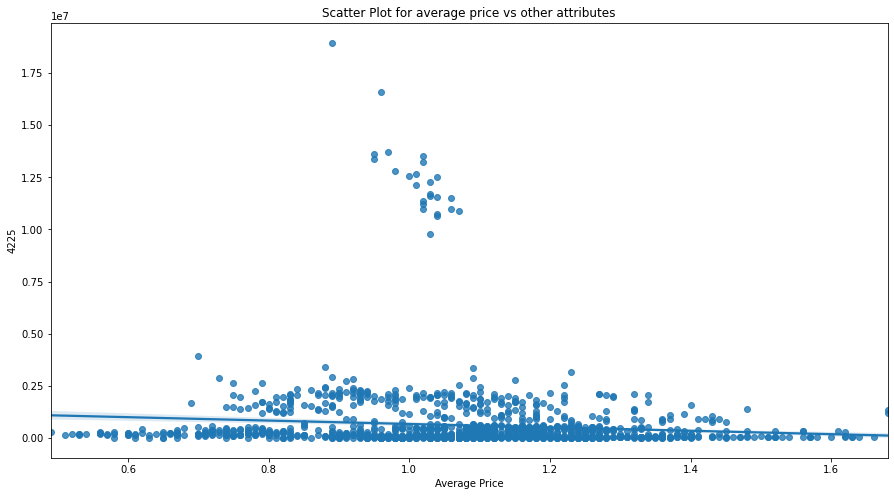

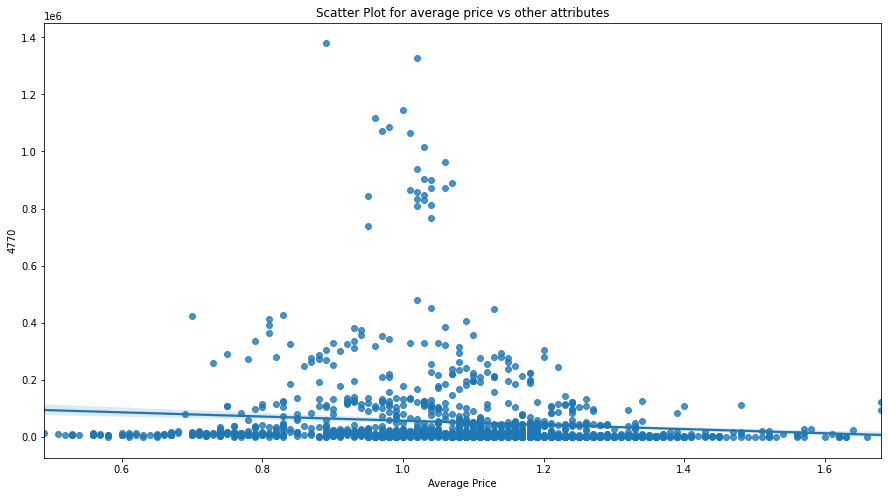

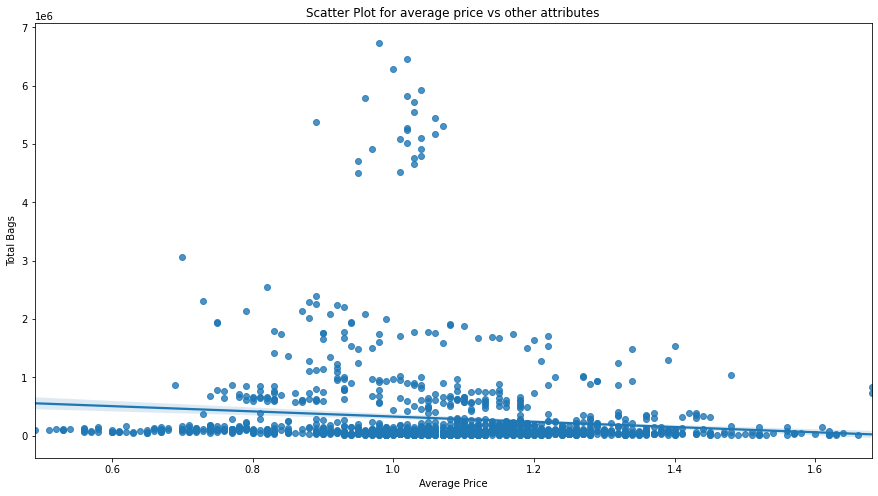

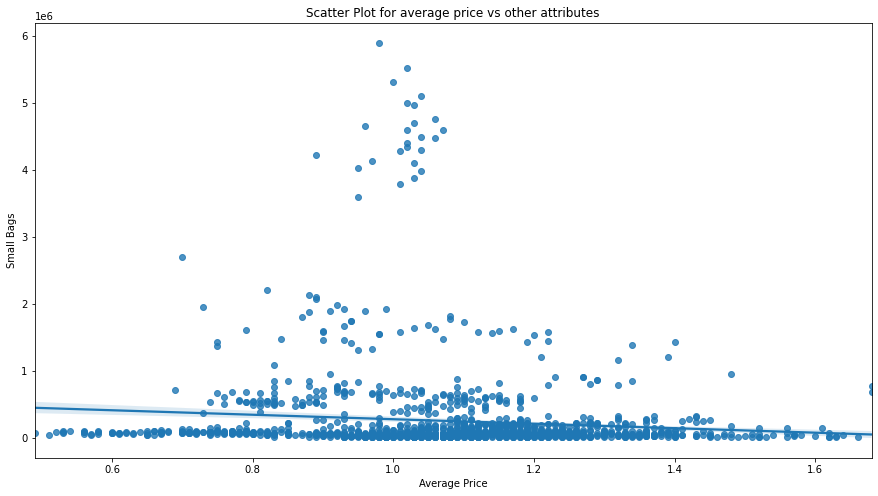

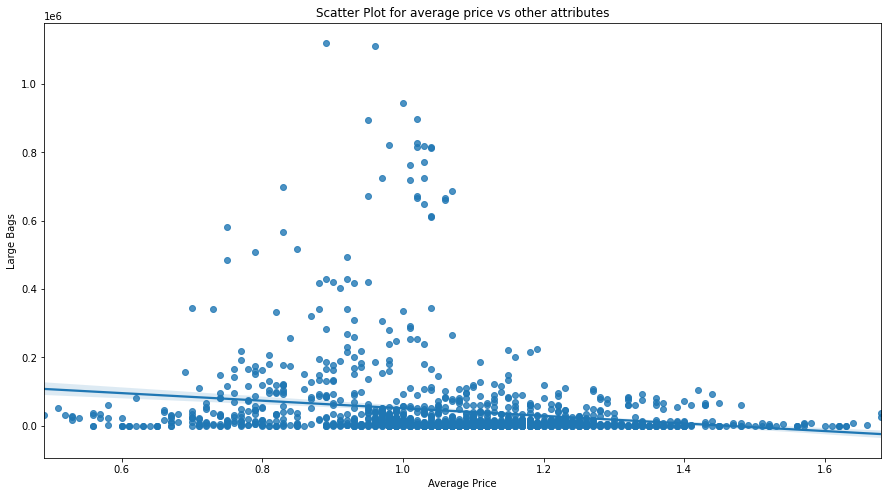

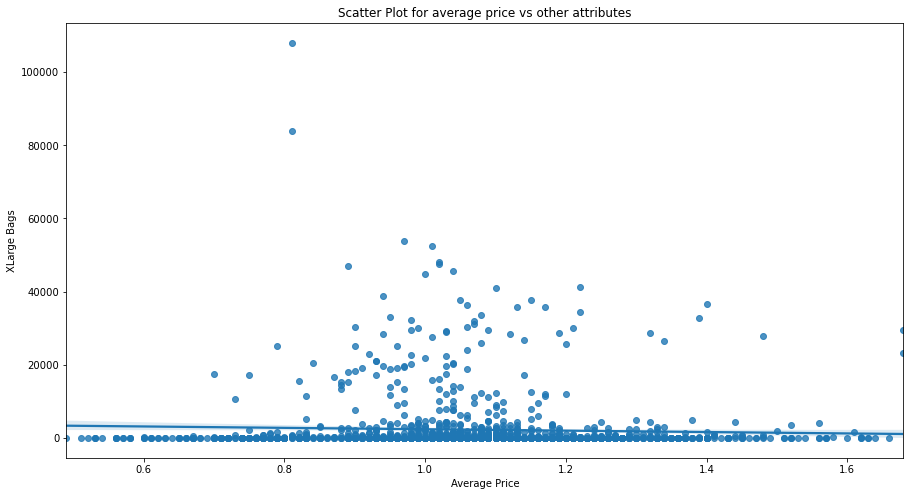

In [18]:
for i in cont_cols:                                      #bivariate analysis
    plt.figure(figsize = (15, 8))
    sns.regplot(df['AveragePrice'], df[i])
    plt.title('Scatter Plot for average price vs other attributes')
    plt.xlabel('Average Price')
    plt.ylabel(i)  
    plt.show()

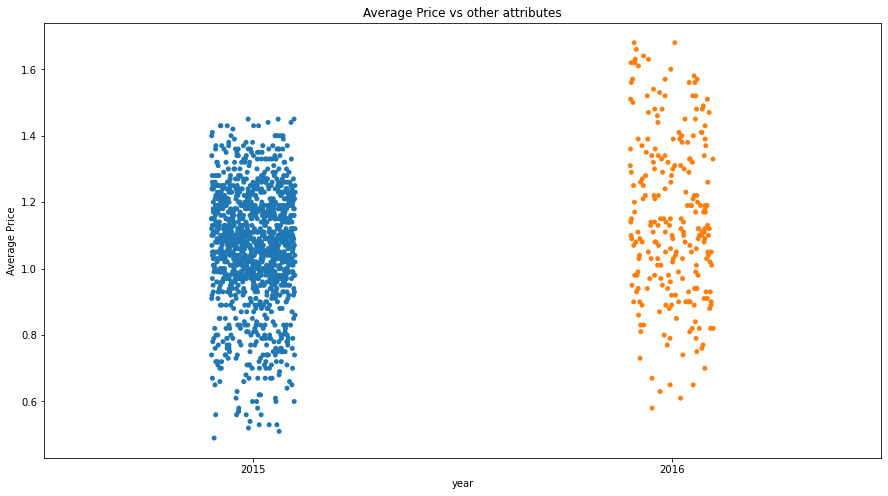

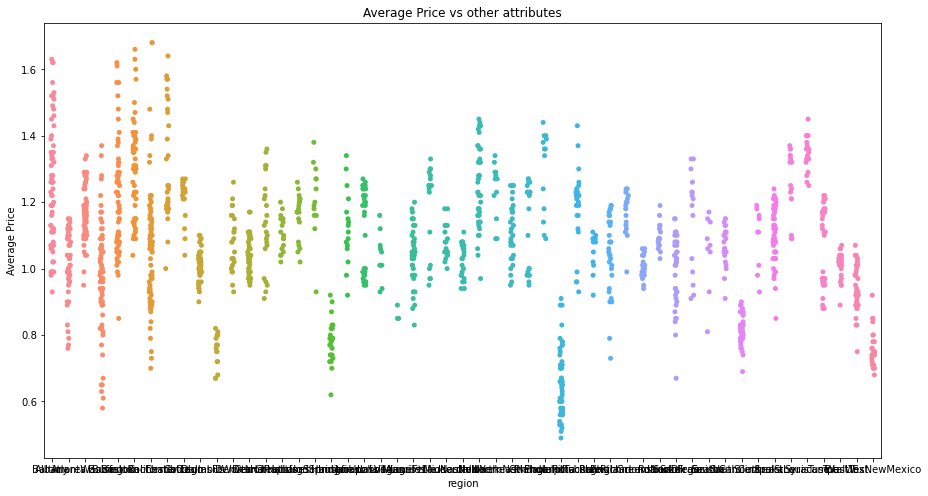

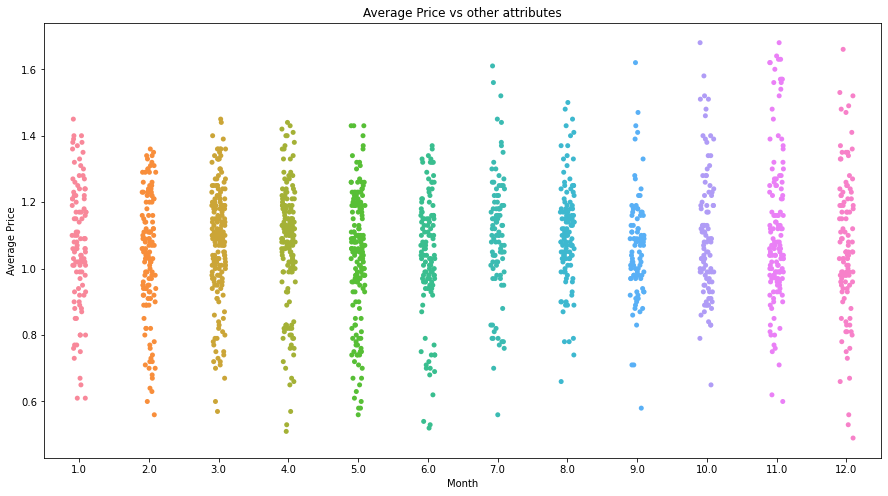

In [19]:
for i in cate_cols:                                          #bivariate analysis
    plt.figure(figsize = (15, 8))
    ax = sns.stripplot(df[i], df['AveragePrice'])
    ax.set(xlabel = i, ylabel = 'Average Price')
    plt.title('Average Price vs other attributes')
    plt.show()

Prices seems to be highest in the month of November and prices have high range in the month of December.



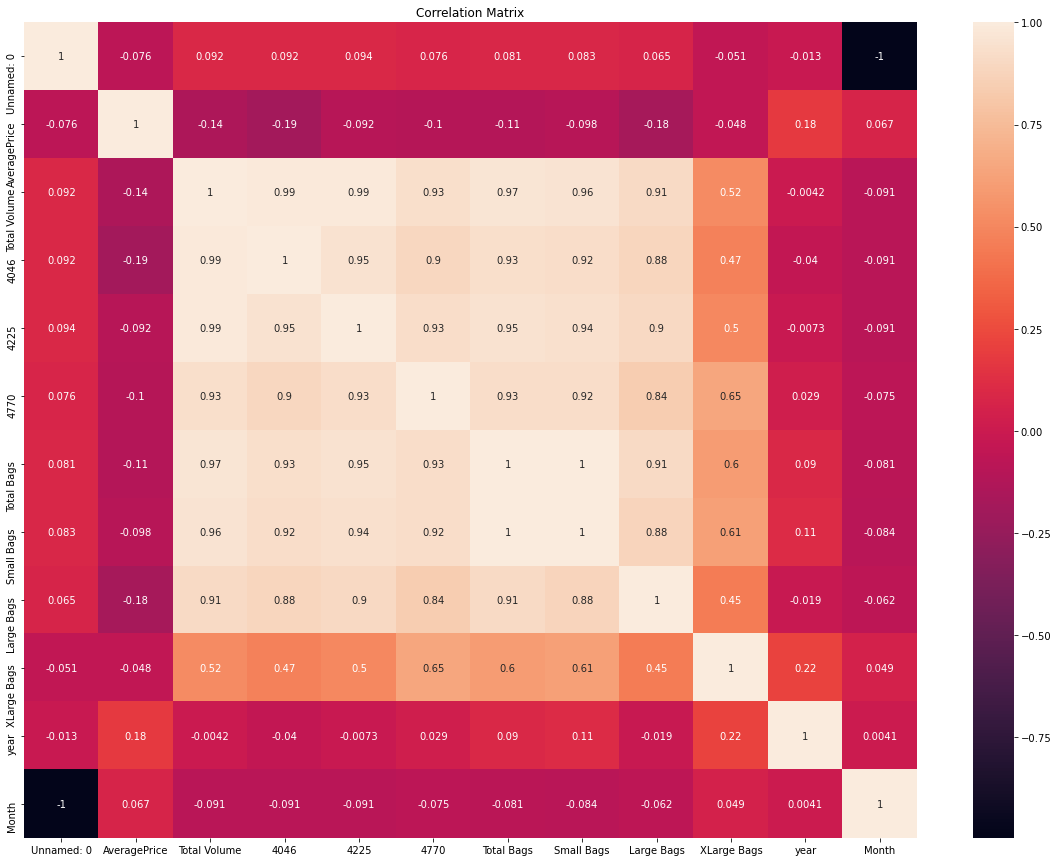

In [20]:
plt.figure(figsize = [20, 15])                             #multivariate analysis
sns.heatmap(df.corr(), annot = True)
plt.title('Correlation Matrix')
plt.show()

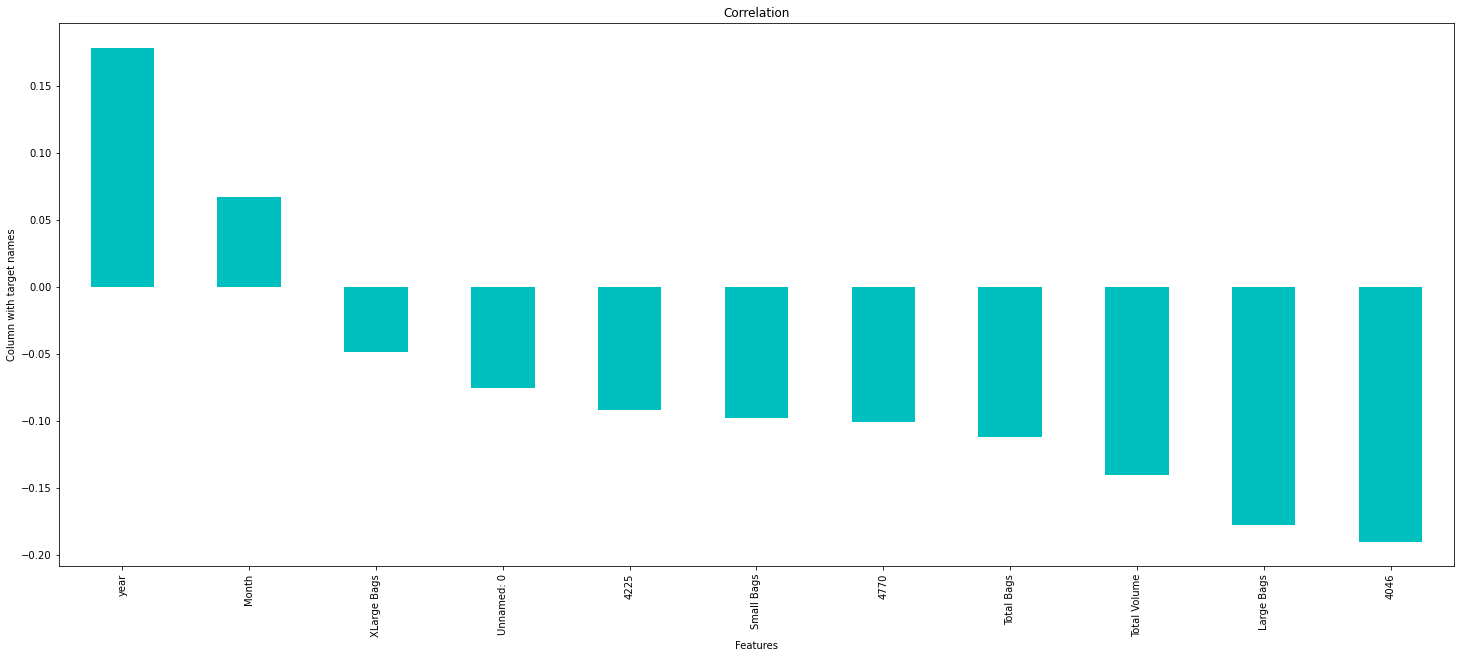

In [21]:
plt.figure(figsize = (25, 10))
df.corr()['AveragePrice'].sort_values(ascending = False).drop(['AveragePrice']).plot(kind = 'bar', color = 'c')
plt.xlabel('Features')
plt.ylabel('Column with target names')
plt.title('Correlation')
plt.show()

Most of the columns have negative correlation with Average Price.

4046 seems to have highest correlation with Average Price at -0.19 followed by large bags at -0.18.

Total volume, 4046, 4225, 4770, Total bags, small bags and large bags all have high correlation amongst them as seen in the heatmap.

# Outliers and Skewness

In [22]:
cont_cols.remove('AveragePrice')


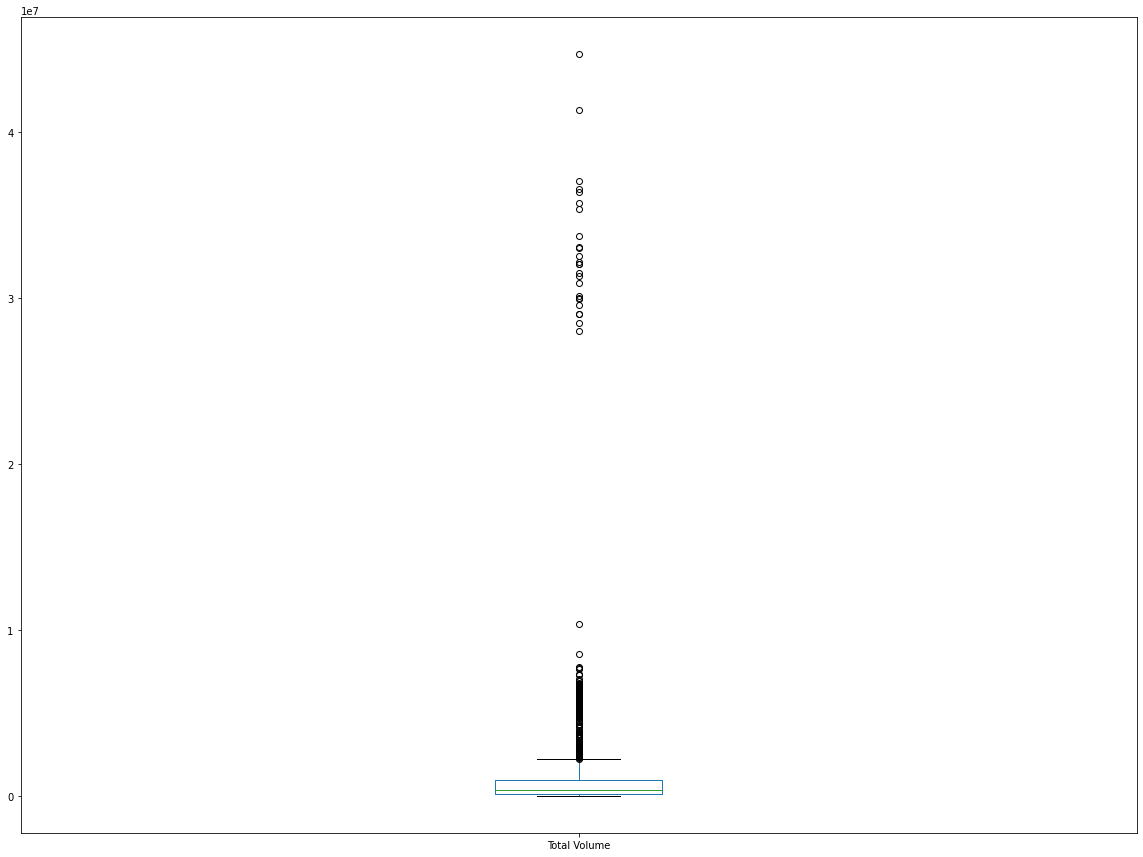

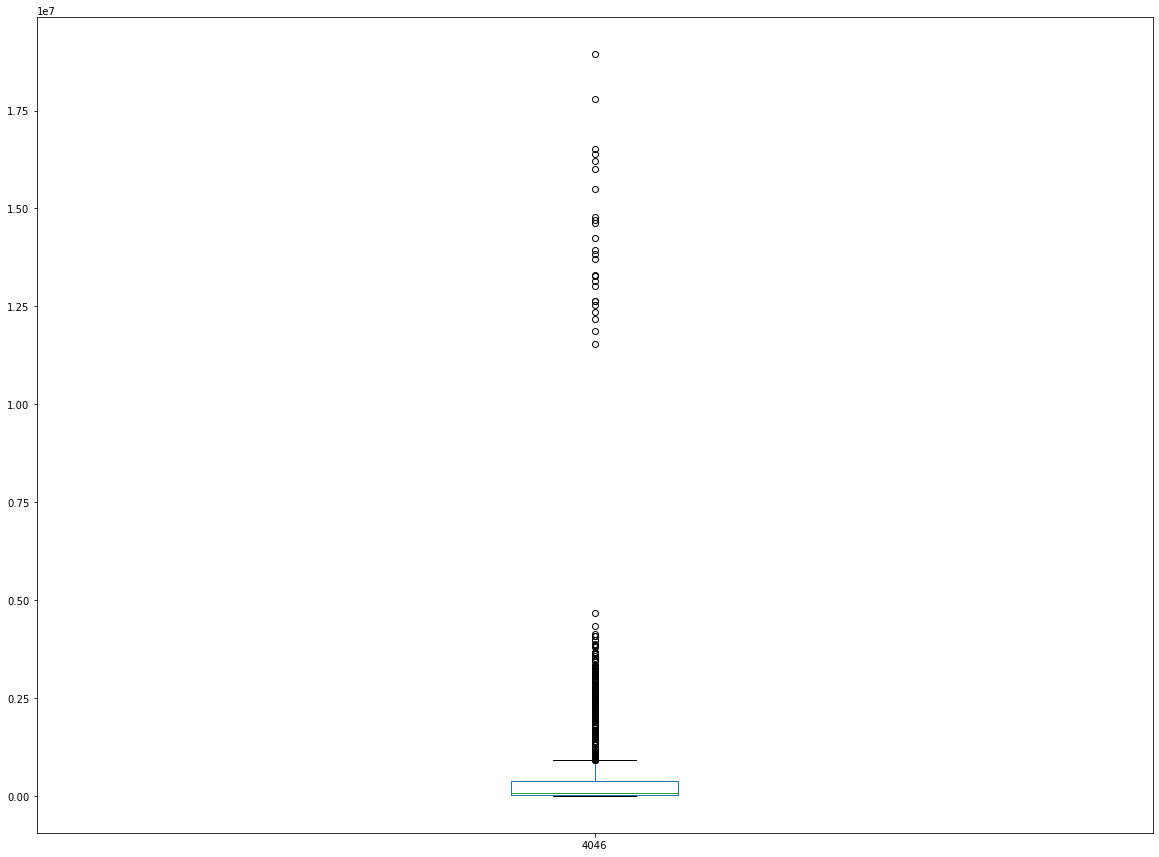

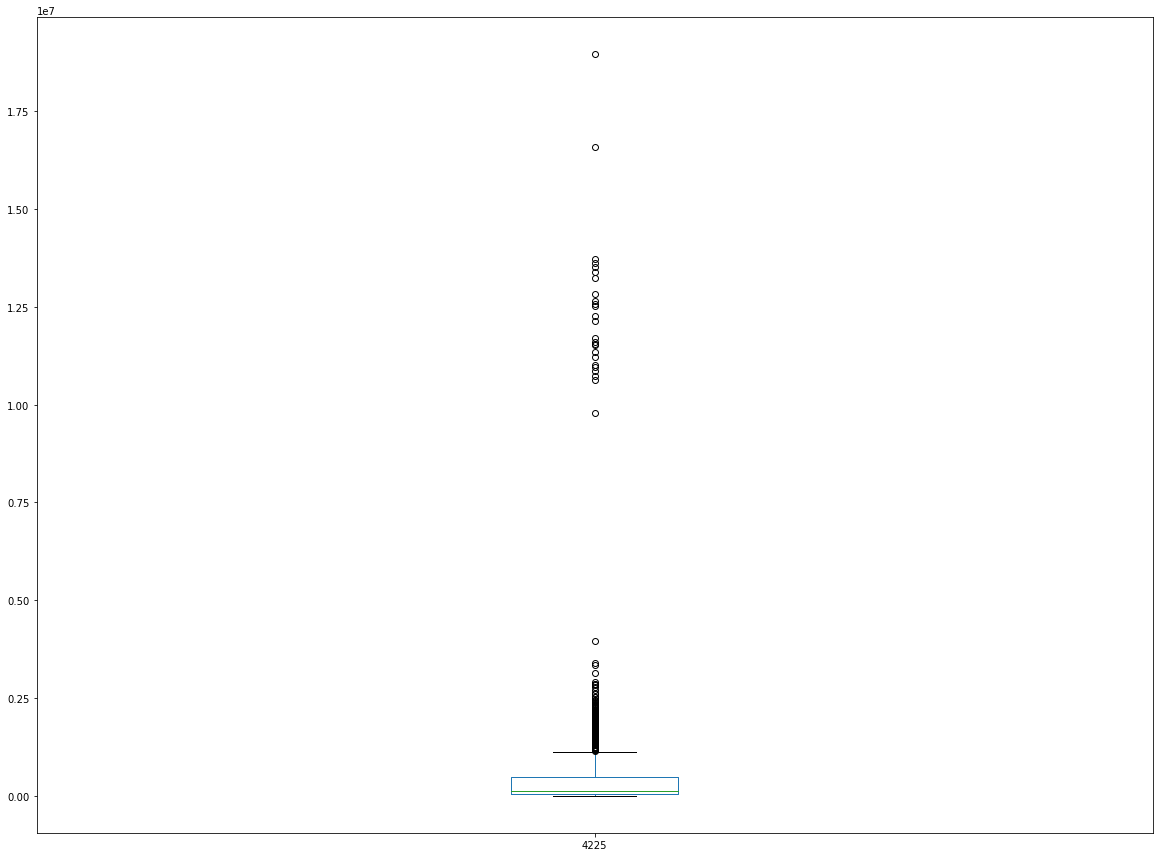

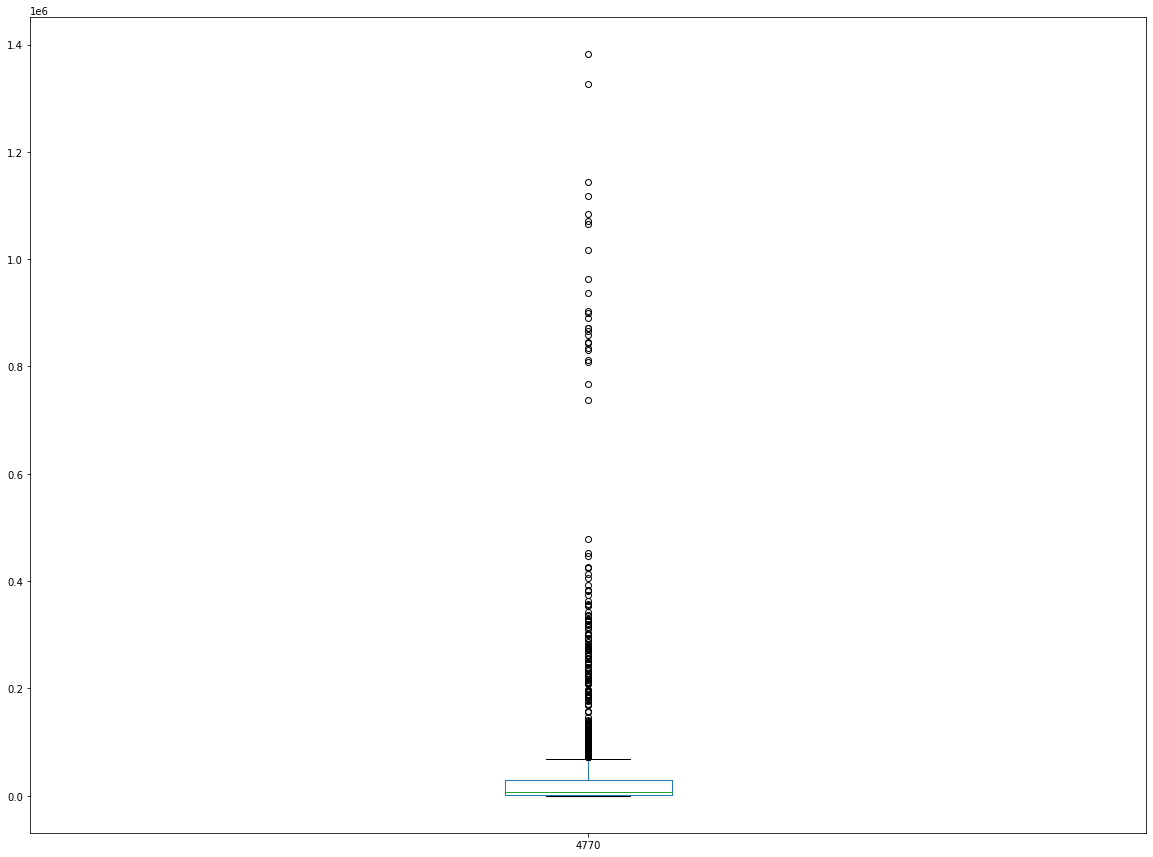

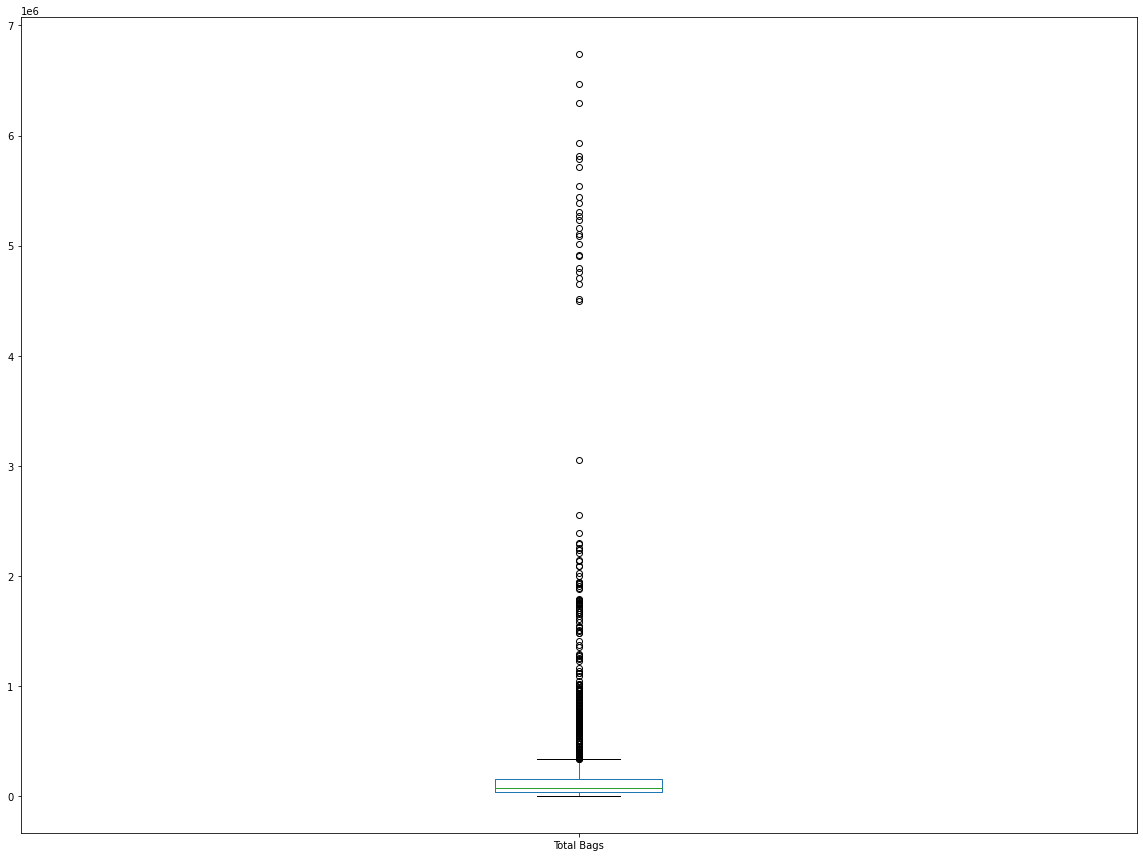

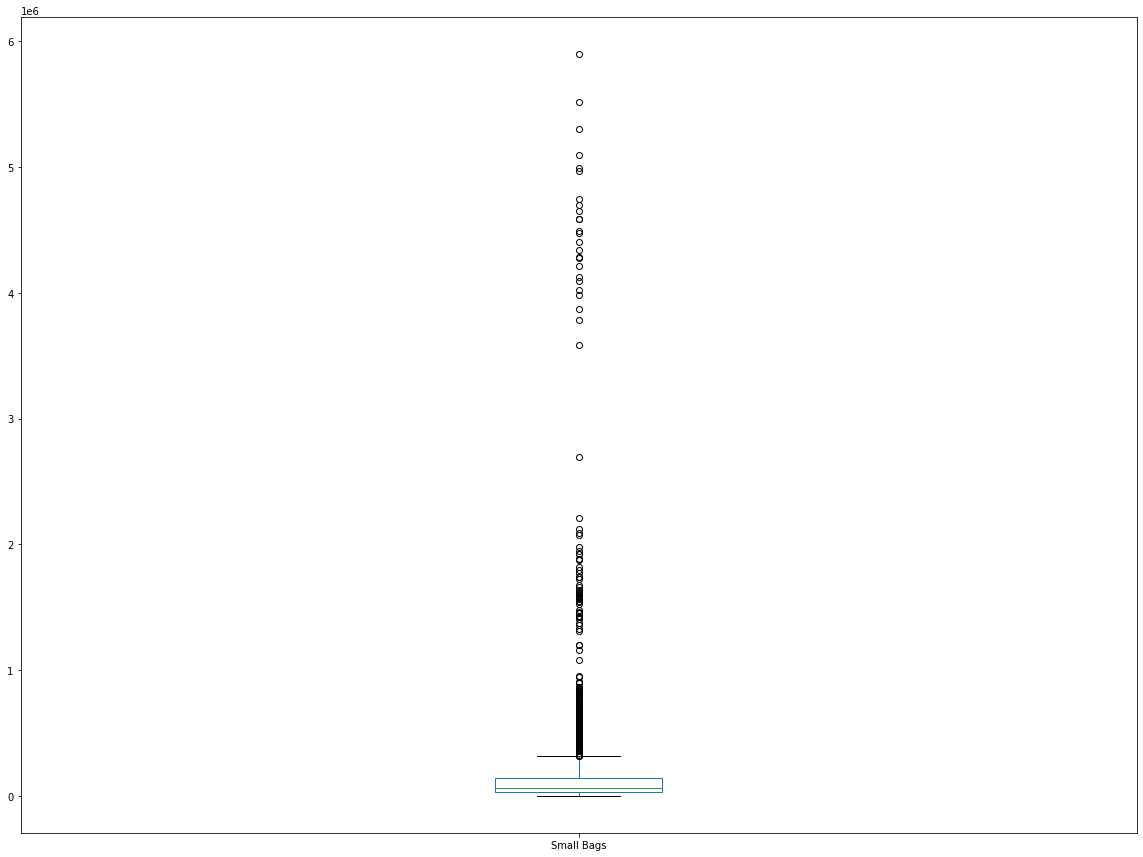

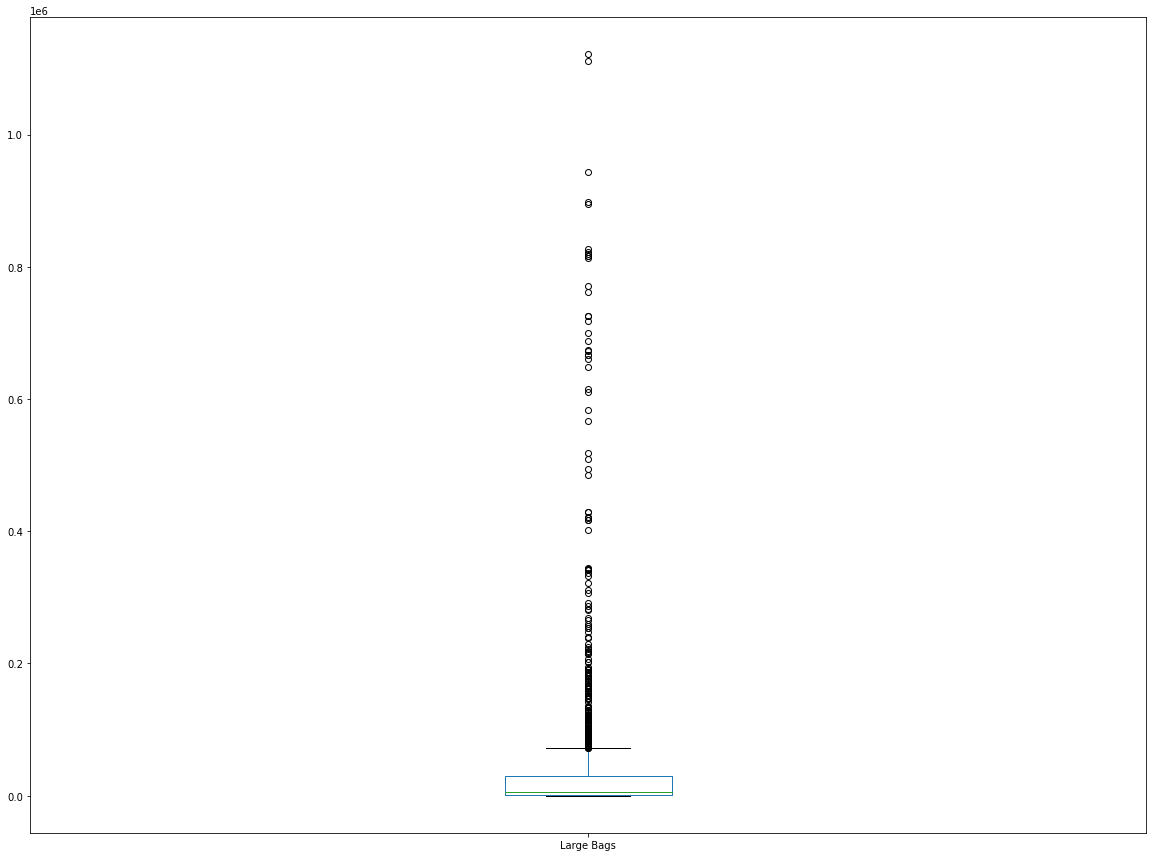

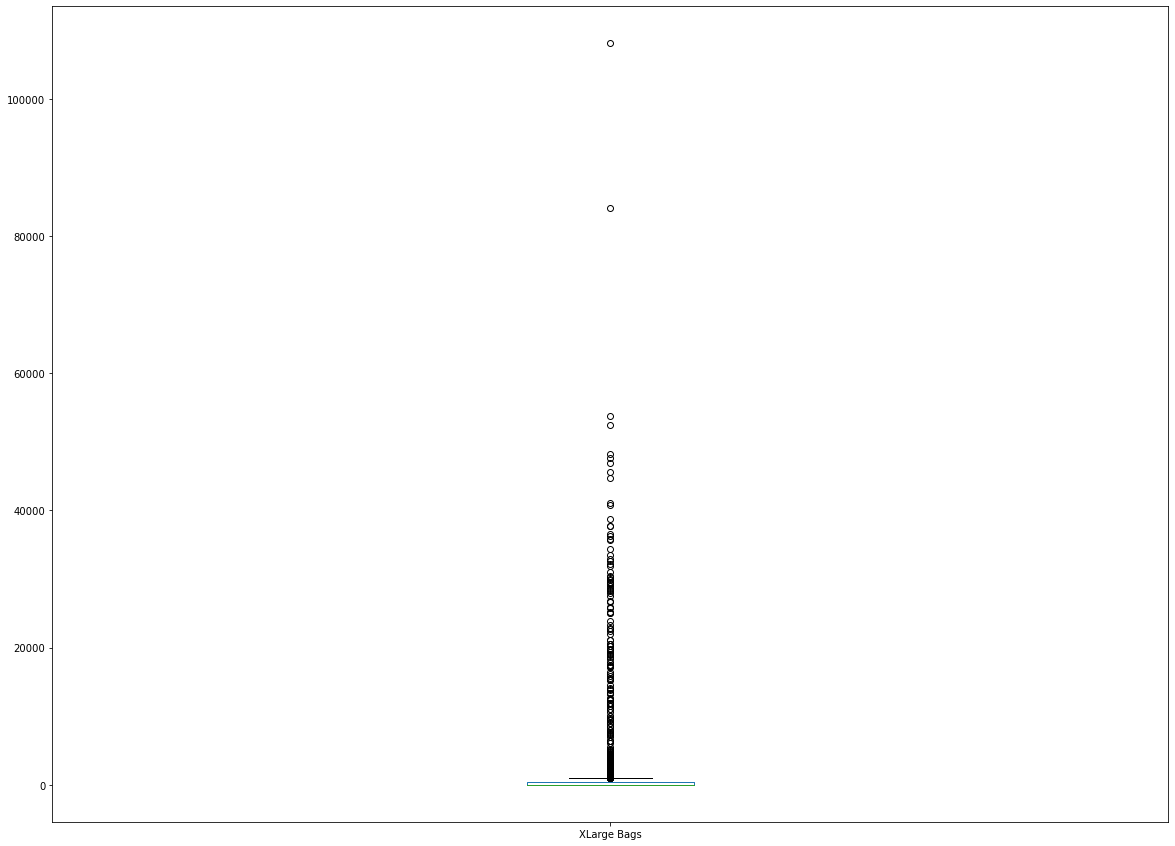

In [23]:
for i in cont_cols:
    plt.figure(figsize = (20, 15))
    df[i].plot.box()


There are too many outliers present in the dataset. We will use z-score to treat these outliers.



In [24]:
from scipy.stats import zscore
z = np.abs(zscore (df[cont_cols]))
z

array([[0.34696593, 0.33149016, 0.33305294, ..., 0.37105465, 0.36004386,
        0.29272731],
       [0.34907791, 0.33167633, 0.33892254, ..., 0.3698118 , 0.36000798,
        0.29272731],
       [0.33478463, 0.33161448, 0.30034767, ..., 0.37192201, 0.35996017,
        0.29272731],
       ...,
       [0.32120275, 0.30820887, 0.33398664, ..., 0.30194984, 0.29095317,
        0.1820374 ],
       [0.31878364, 0.30423037, 0.33356795, ..., 0.29836419, 0.29078309,
        0.29272731],
       [0.3201721 , 0.30987728, 0.33320927, ..., 0.29557902, 0.26226571,
        0.29272731]])

In [25]:
threshold = 3
print (np.where(z>3))

(array([ 398,  401,  409,  412,  412, 1016, 1017, 1059, 1182, 1182, 1182,
       1182, 1182, 1182, 1182, 1182, 1183, 1183, 1183, 1183, 1183, 1183,
       1183, 1184, 1184, 1184, 1184, 1184, 1184, 1184, 1184, 1185, 1185,
       1185, 1185, 1185, 1185, 1185, 1186, 1186, 1186, 1186, 1186, 1186,
       1186, 1187, 1187, 1187, 1187, 1187, 1187, 1187, 1187, 1188, 1188,
       1188, 1188, 1188, 1188, 1188, 1189, 1189, 1189, 1189, 1189, 1189,
       1189, 1189, 1190, 1190, 1190, 1190, 1190, 1190, 1190, 1190, 1191,
       1191, 1191, 1191, 1191, 1191, 1191, 1191, 1192, 1192, 1192, 1192,
       1192, 1192, 1192, 1193, 1193, 1193, 1193, 1193, 1193, 1193, 1194,
       1194, 1194, 1194, 1194, 1194, 1194, 1195, 1195, 1195, 1195, 1195,
       1195, 1195, 1195, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1197,
       1197, 1197, 1197, 1197, 1197, 1197, 1198, 1198, 1198, 1198, 1198,
       1198, 1198, 1198, 1199, 1199, 1199, 1199, 1199, 1199, 1199, 1200,
       1200, 1200, 1200, 1200, 1200, 1200, 1201, 1

In [26]:
df_new = df [(z<3).all(axis = 1)]


In [27]:
df_new.shape


(1439, 13)

All rows having z-score of more than 3 were dropped from the data.

81 rows dropped from the dataset.

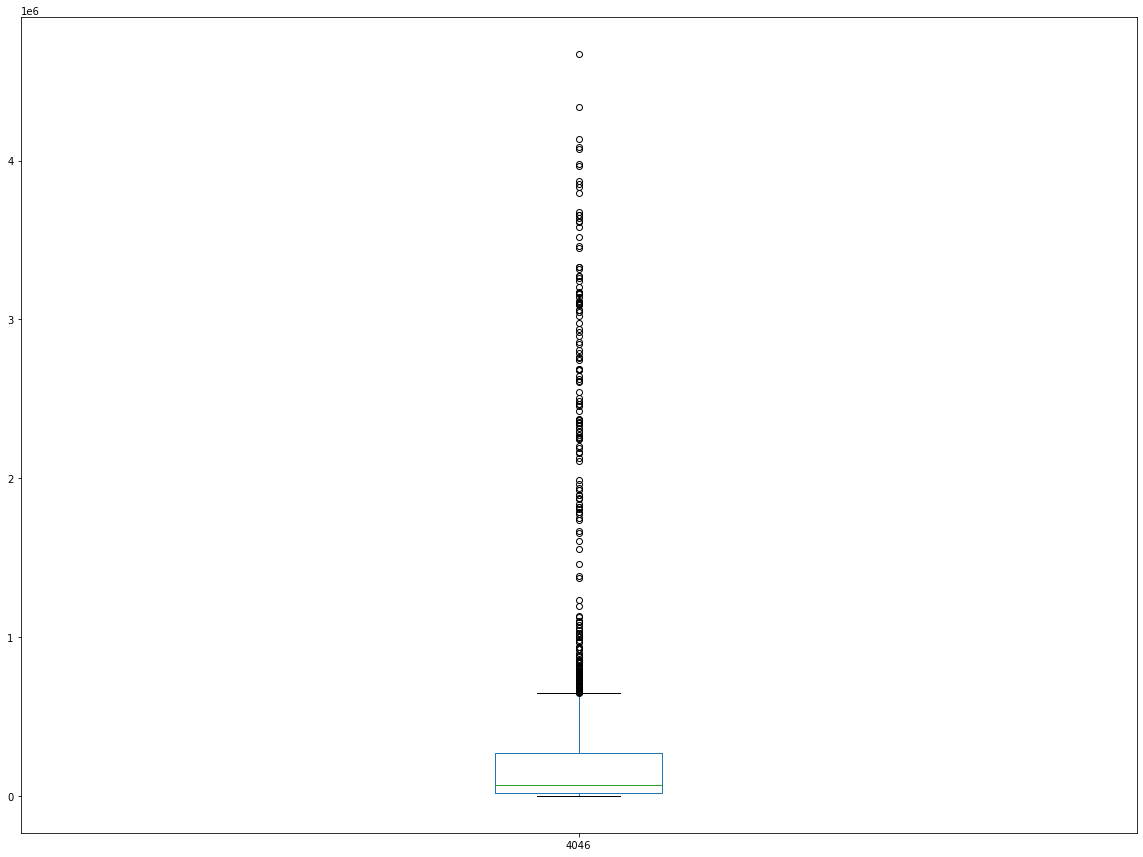

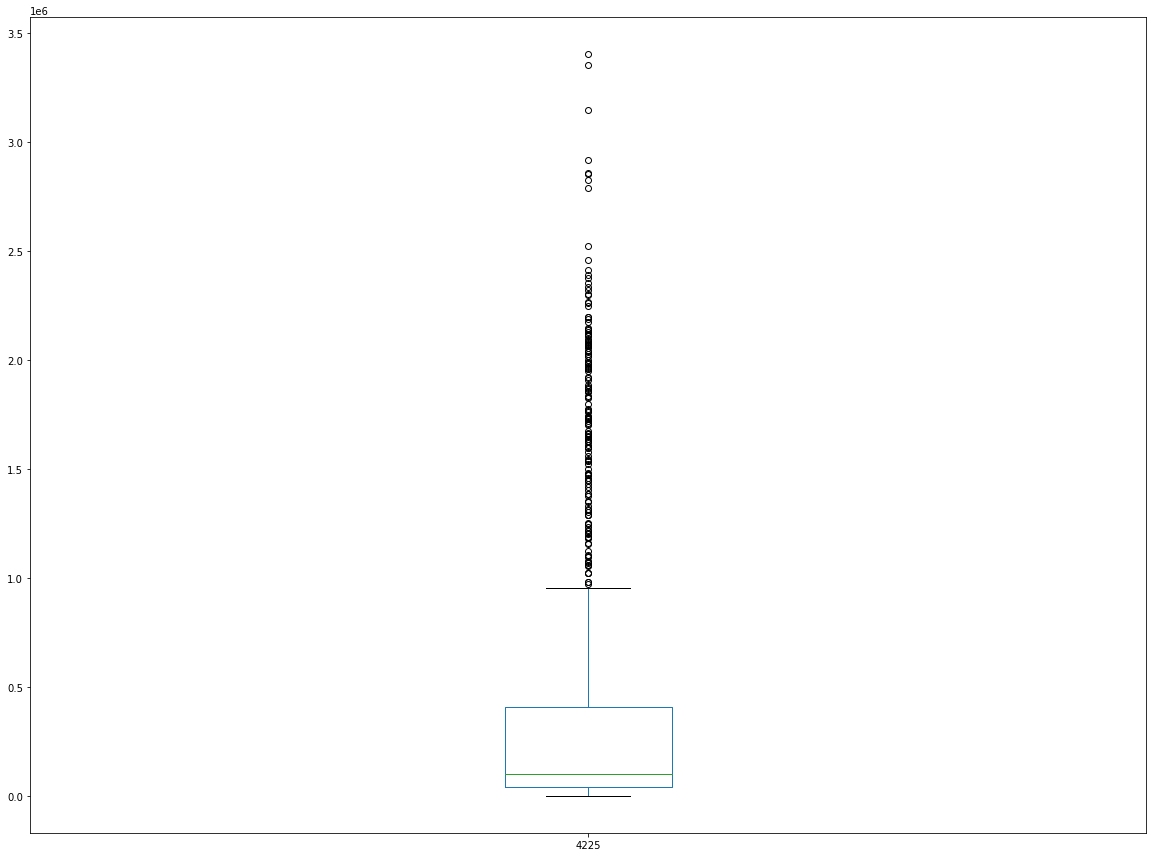

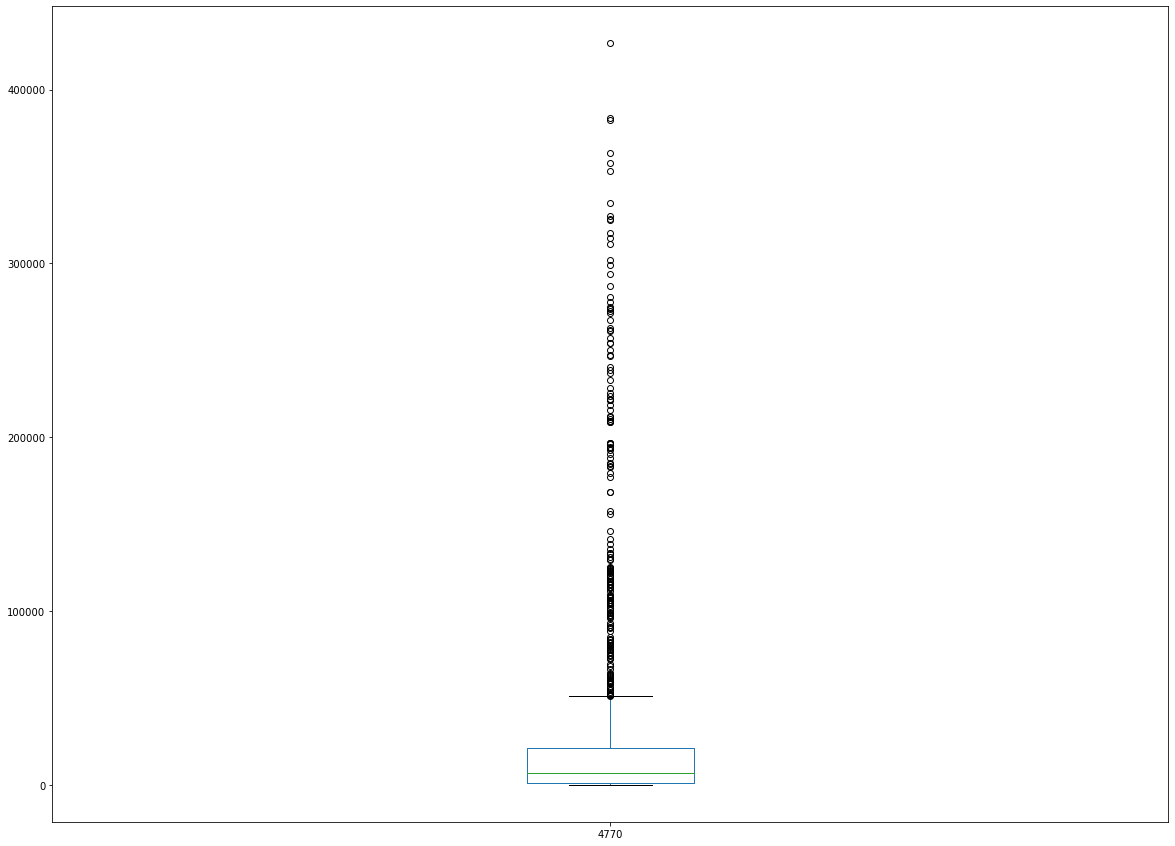

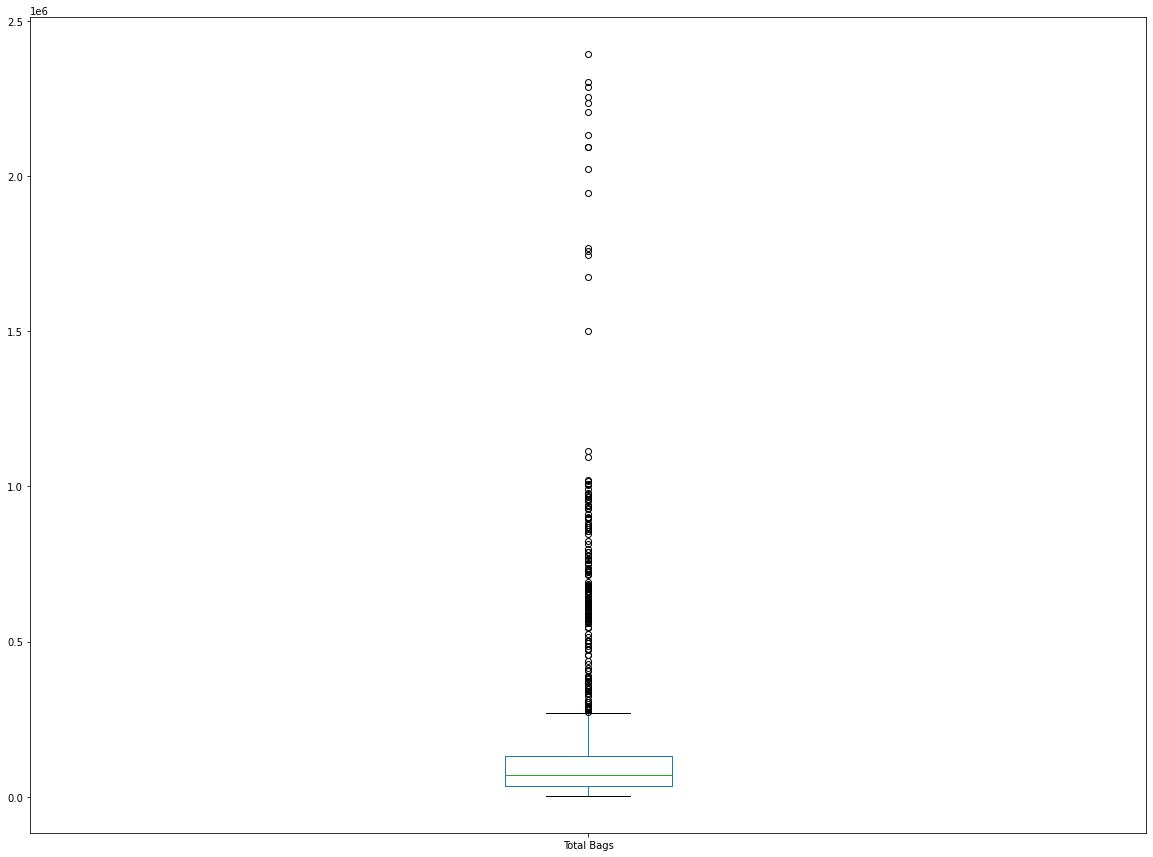

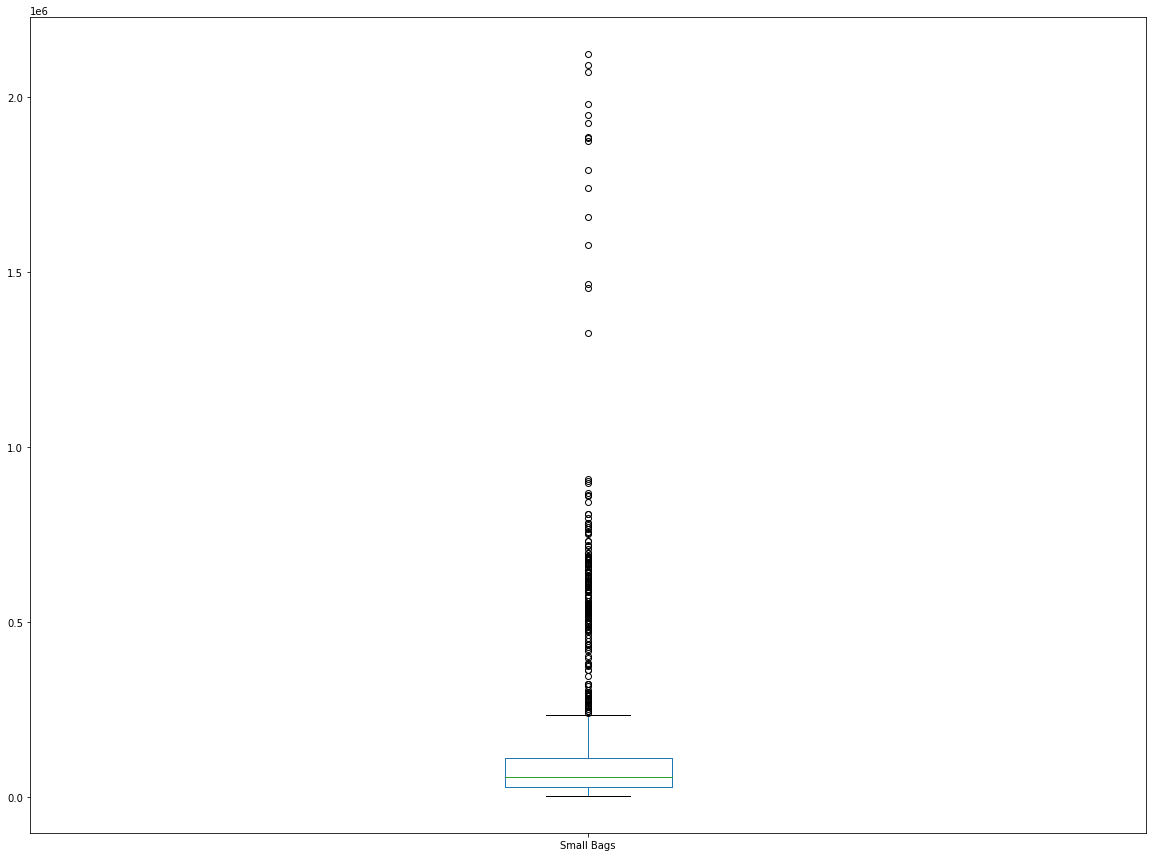

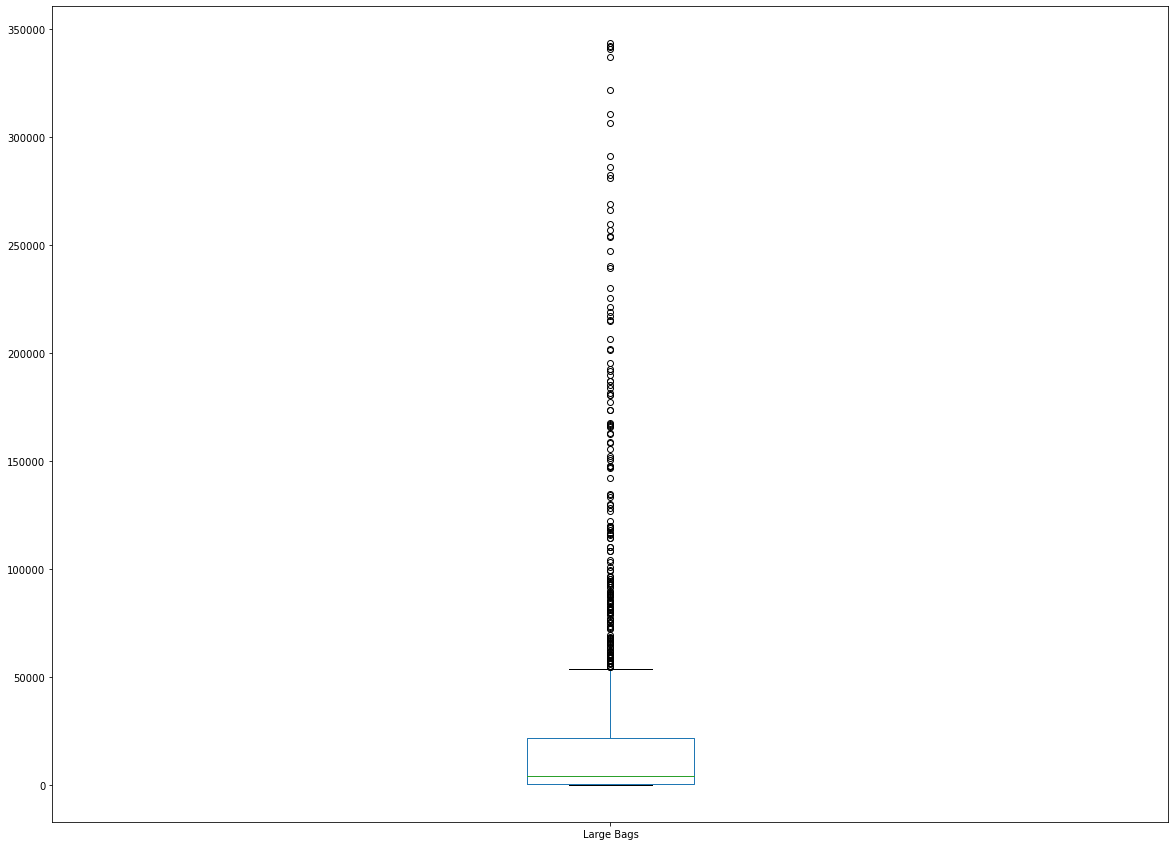

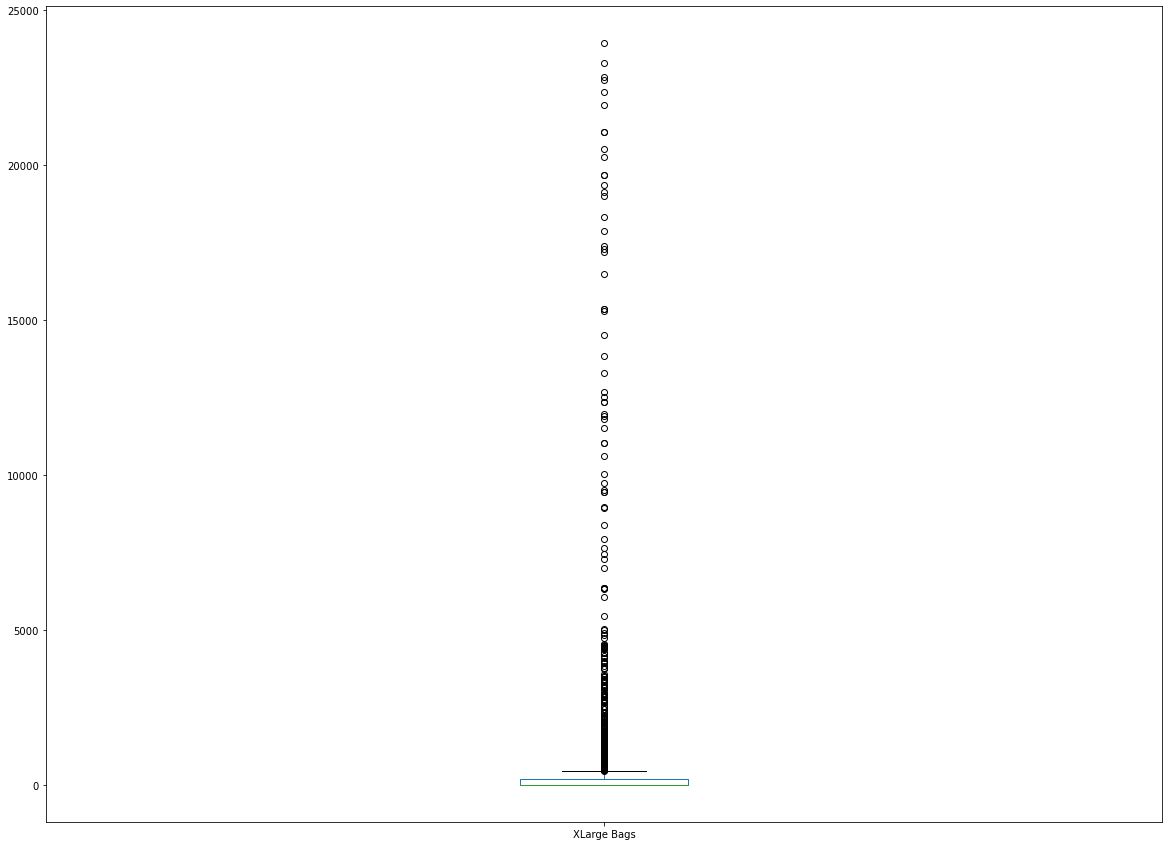

In [28]:
for i in cont_cols[1:]:
    plt.figure(figsize = (20, 15))
    df_new[i].plot.box()

In [29]:
df_new.skew()


Unnamed: 0     -0.246136
AveragePrice   -0.164097
Total Volume    2.699607
4046            3.117671
4225            2.364213
4770            3.329694
Total Bags      4.153979
Small Bags      4.394953
Large Bags      3.521463
XLarge Bags     5.107058
year            1.992181
Month           0.244263
dtype: float64

Total Volume, 4046, 4225, 4770, Total Bags, Small Bags, Large Bags, Xlarge Bags all have skewness above the threshold value of +-0.5.



In [30]:
from sklearn.preprocessing import power_transform        #removing skewness
df_new[cont_cols] = power_transform(df_new[cont_cols], method='yeo-johnson')        #using yeo-johnson method due to presence of negative skewness
df_new = pd.DataFrame(df_new, columns = df_new.columns)

In [31]:
df_new.skew()


Unnamed: 0     -0.246136
AveragePrice   -0.164097
Total Volume    0.000000
4046           -0.026242
4225            0.000767
4770           -0.055180
Total Bags      0.000000
Small Bags      0.000000
Large Bags     -0.118151
XLarge Bags     0.478894
year            1.992181
Month           0.244263
dtype: float64

In [32]:
x = df_new.drop('AveragePrice', axis = 1)
y = df_new['AveragePrice']

In [33]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
x['region'] = label_encoder.fit_transform(x['region'])

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)

# Best Random State

In [35]:
maxr2score = 0
maxRS = 0

for i in range (1, 500):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = i)
    LR = LinearRegression()
    LR.fit(x_train, y_train)
    predrf = LR.predict(x_test)
    r2 = r2_score(y_test, predrf)
    if r2>maxr2score:
        maxr2score = r2
        maxRS = i
print ('Max R2 score obtained is', maxr2score, 'on Random State', maxRS)

Max R2 score obtained is 0.4050605361871633 on Random State 75


# Creating Train Test Split

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 75)


In [38]:
LR = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [LR, dt, rf]
for i in models:
    print (i)
    i.fit(x_train, y_train)
    pred = i.predict(x_test)
    print (r2_score(y_test, pred))
    print (mean_squared_error(y_test, pred))
    print (mean_absolute_error(y_test, pred))

LinearRegression()
0.4050605361871633
0.02311736615368914
0.11796089249103385
DecisionTreeRegressor()
0.6627801381576179
0.01310324074074074
0.07837962962962963
RandomForestRegressor()
0.8111017984021731
0.007339955000000003
0.060502314814814835


In [39]:
for i in models:
    cvs = cross_val_score(i, x, y, cv = 5)
    print ('Cross Validation Score for ',i, ' model is :', cvs.mean())
    print (' ')

Cross Validation Score for  LinearRegression()  model is : -7963116077026.239
 
Cross Validation Score for  DecisionTreeRegressor()  model is : -0.7586528752324427
 
Cross Validation Score for  RandomForestRegressor()  model is : 0.018170036186347584
 


Difference between R2 score and cross validation score is least in Random Forest model, hence we'll work on Random Forest Model.



# Hypertuning

In [40]:
from sklearn.model_selection import GridSearchCV


In [41]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['mse', 'mae']
}

In [43]:
GCV = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)
GCV.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [44]:
GCV.best_params_


{'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200}

In [45]:

rfr = RandomForestRegressor(random_state=75, max_features='sqrt', n_estimators= 200, max_depth=8, criterion='mse')
rfr.fit(x_train, y_train)
predrfr = rfr.predict(x_test)
print (r2_score(y_test, predrfr))
print (mean_squared_error(y_test, predrfr))
print (mean_absolute_error(y_test, predrfr))

0.7798245899135952
0.008555283155005698
0.06956819097598108


In [46]:
cvs = cross_val_score(rfr, x, y, cv = 5)
print ('Cross Validation Score for ',rfr, ' model is :', cvs.mean())

Cross Validation Score for  RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=200,
                      random_state=75)  model is : 0.23695658325545357


After hypertuning with GridSearchCV the difference between R2 score and cross validation score decreased, with rise in cross val score.



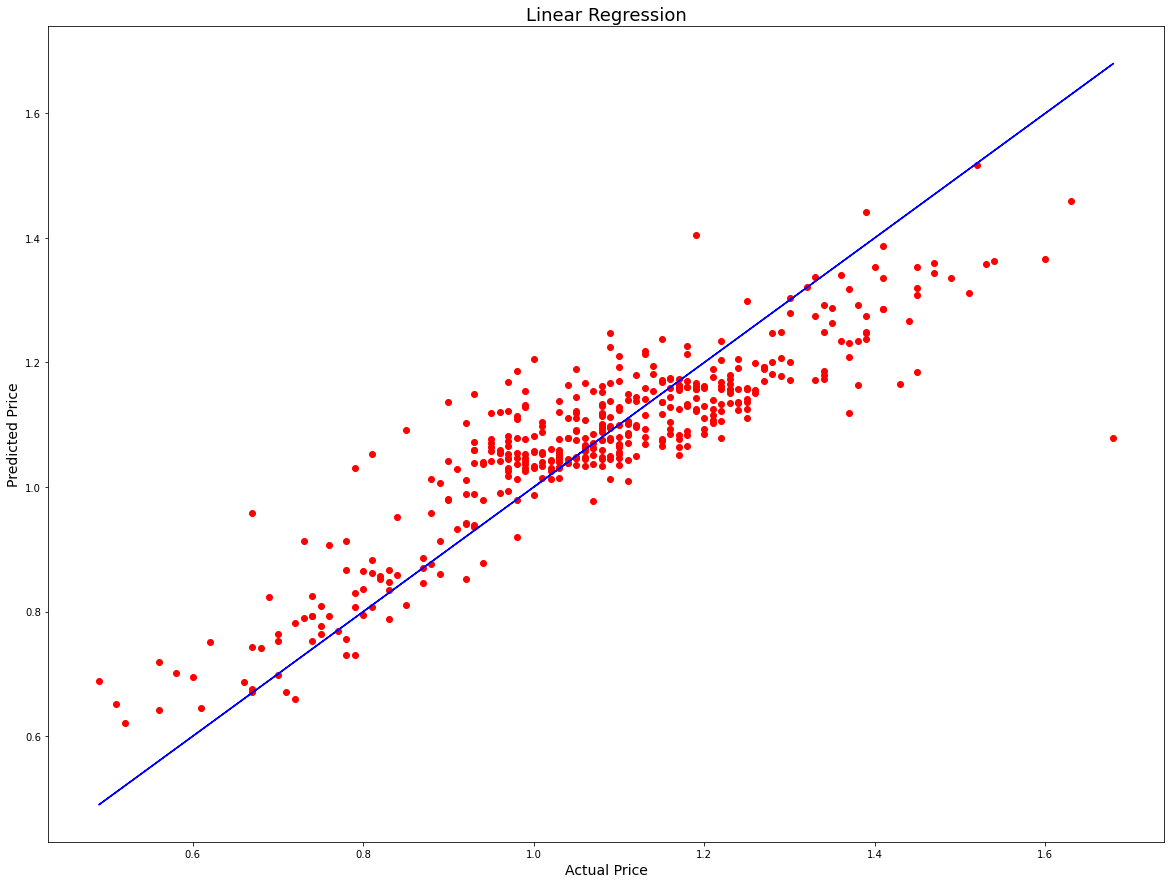

In [47]:
plt.figure(figsize = (20, 15))
plt.scatter(x = y_test, y = predrfr, color = 'r')
plt.plot(y_test, y_test, color = 'b')
plt.xlabel('Actual Price', fontsize = 14)
plt.ylabel('Predicted Price', fontsize = 14)
plt.title('Linear Regression', fontsize = 18)
plt.show()

The blue line represents the actual values while the red dotes are the predicted values.



In [48]:
import pickle

filename = 'AvocadoRfr.pkl'
pickle.dump(rfr, open(filename, 'wb'))

# Conclusion

In [49]:
loaded_model = pickle.load(open('AvocadoRfr.pkl', 'rb'))
result = loaded_model.score(x_test, y_test)
print (result)

0.7798245899135952


In [50]:
conclusion = pd.DataFrame([loaded_model.predict(x_test)[:], predrfr[:]], index = ['Predicted', 'Original'])
conclusion

,0,1,2,3,4,5,6,7,8,9,...,422,423,424,425,426,427,428,429,430,431
Predicted,1.167051,0.687202,0.988131,1.189221,1.046323,1.113747,1.179704,1.085622,0.756339,1.046549,...,0.932931,1.08346,0.753317,1.119016,1.135009,0.882599,1.054283,1.031225,1.118845,1.033884
Original,1.167051,0.687202,0.988131,1.189221,1.046323,1.113747,1.179704,1.085622,0.756339,1.046549,...,0.932931,1.08346,0.753317,1.119016,1.135009,0.882599,1.054283,1.031225,1.118845,1.033884


The predict and original values are same so our model is perfect.

# HR Analytics Project


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
df = pd.read_csv('HR.csv')
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


# EDA

In [54]:
df.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [55]:
df.keys()


Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

In [56]:
df.groupby('left').describe()


satisfaction_level                                                    \
                  count      mean       std   min   25%   50%   75%   max   
left                                                                        
0               11428.0  0.666810  0.217104  0.12  0.54  0.69  0.84  1.00   
1                3571.0  0.440098  0.263933  0.09  0.13  0.41  0.73  0.92   

     last_evaluation            ... Work_accident      promotion_last_5years  \
               count      mean  ...           75%  max                 count   
left                            ...                                            
0            11428.0  0.715473  ...           0.0  1.0               11428.0   
1             3571.0  0.718113  ...           0.0  1.0                3571.0   

                                                   
          mean       std  min  25%  50%  75%  max  
left                                               
0     0.026251  0.159889  0.0  0.0  0.0  0.0  1.0  
1     0.005321  0.072759  0.0  0.0  0.0  0.0  1.0  

[2 rows x 56 columns]

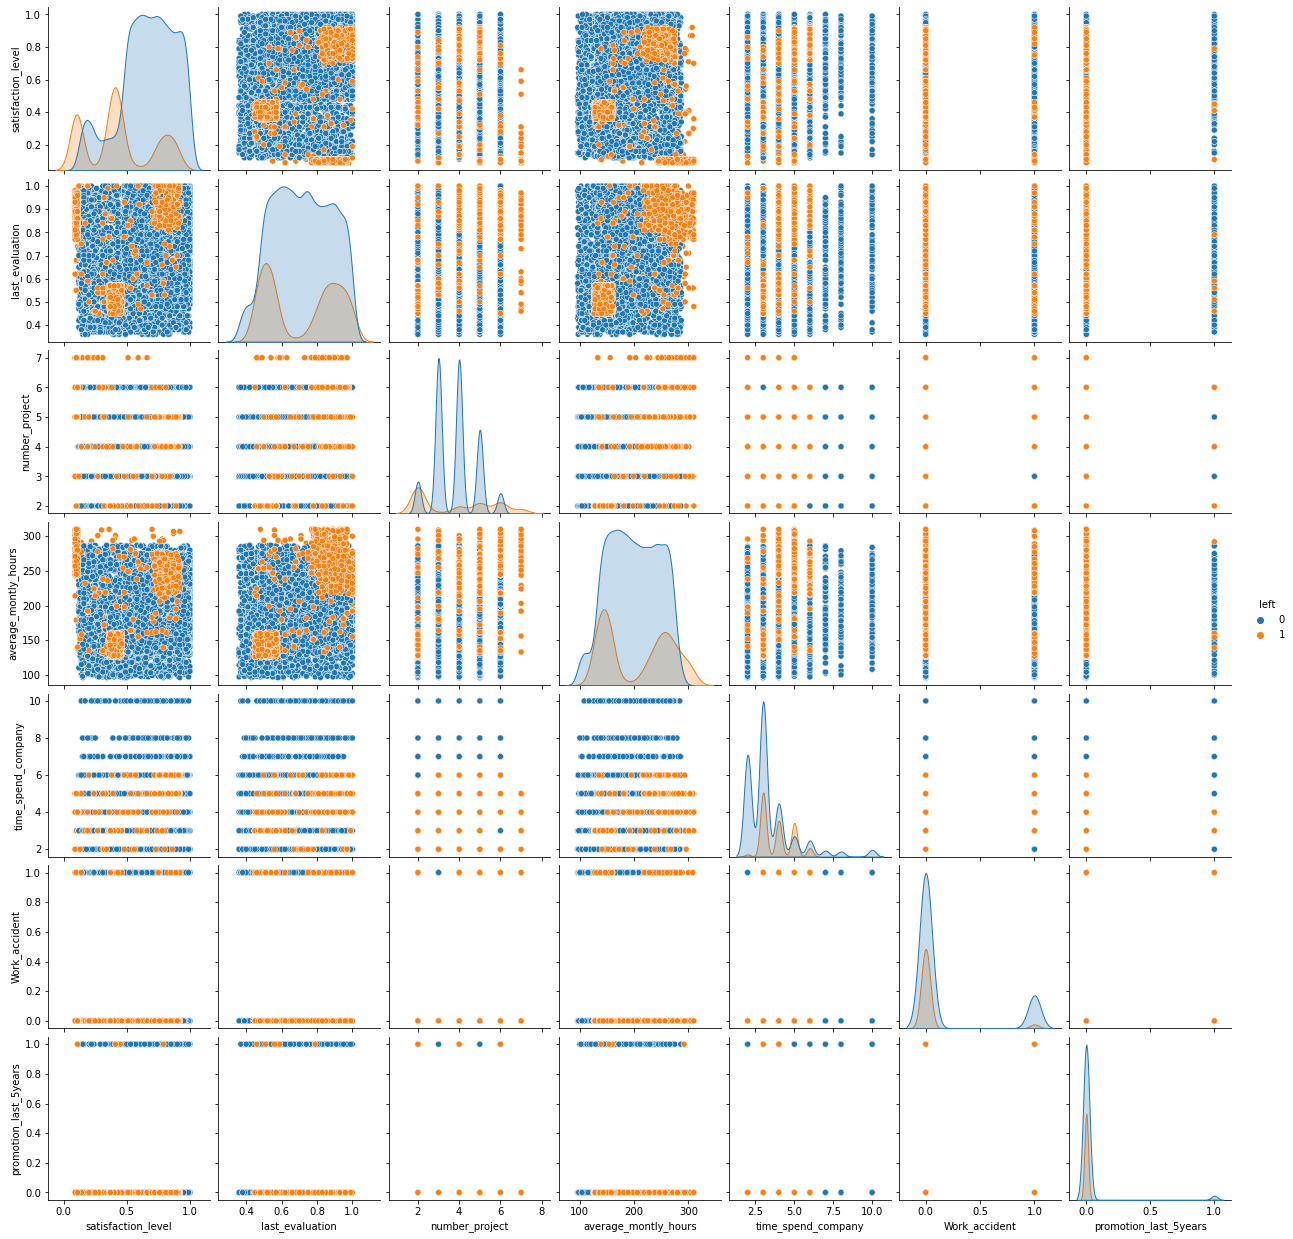

In [57]:
sns.pairplot(df, hue='left')


In [58]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


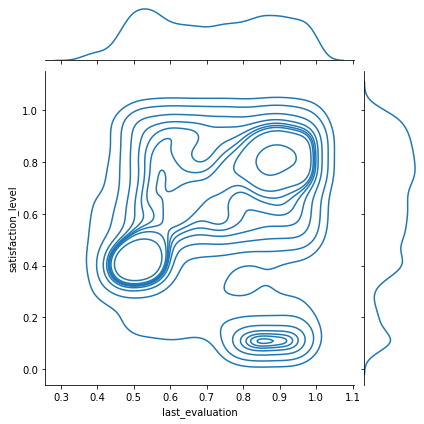

In [59]:
sns.jointplot(x=df['last_evaluation'], y=df['satisfaction_level'], kind='kde')


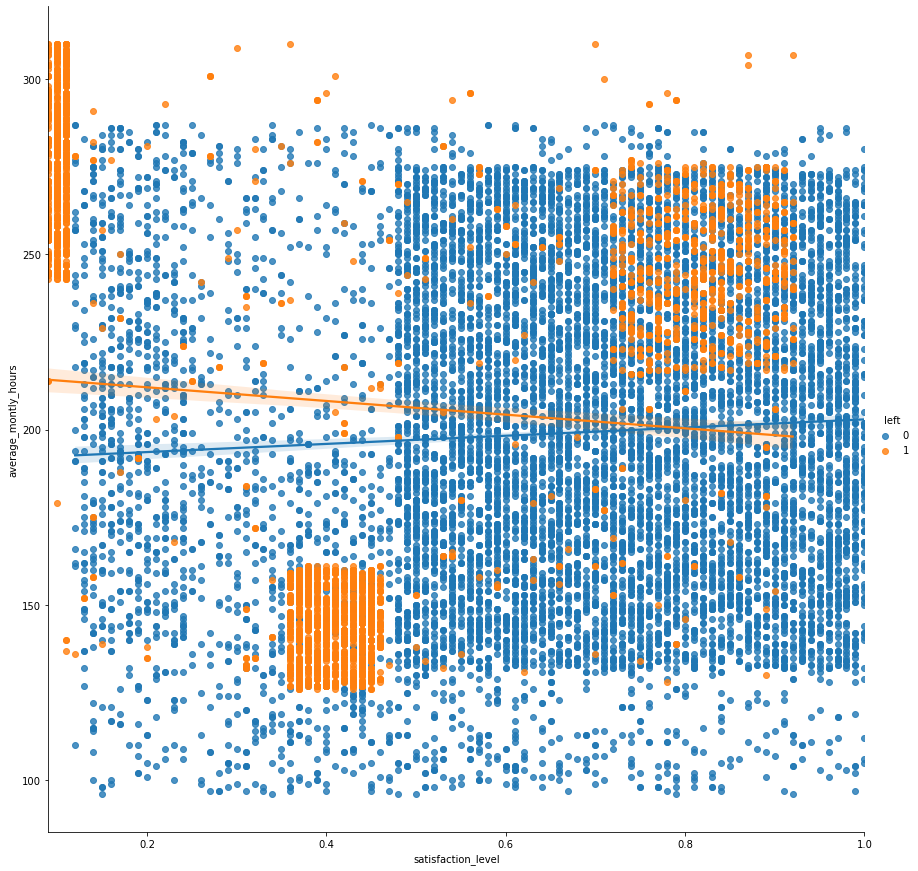

In [60]:
sns.lmplot(data=df, x='satisfaction_level', y='average_montly_hours', size=12, hue='left')


In [61]:
df.corr()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


<AxesSubplot:>

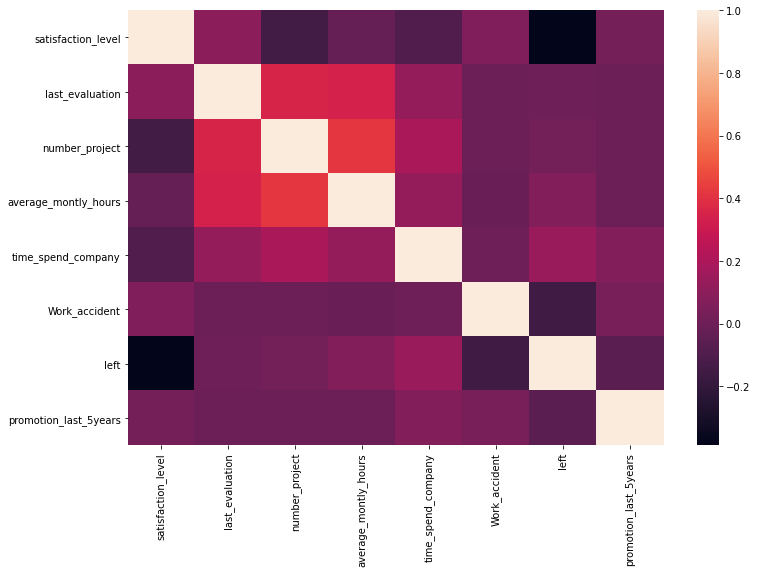

In [62]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=False)

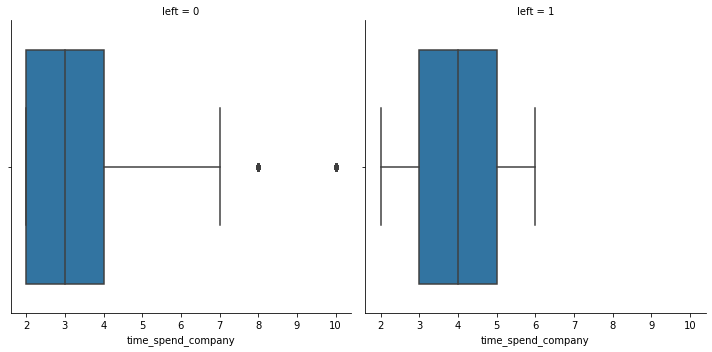

In [63]:
g = sns.FacetGrid(df, col = 'left', size=5)
g.map(sns.boxplot, 'time_spend_company')

<AxesSubplot:xlabel='time_spend_company', ylabel='left'>

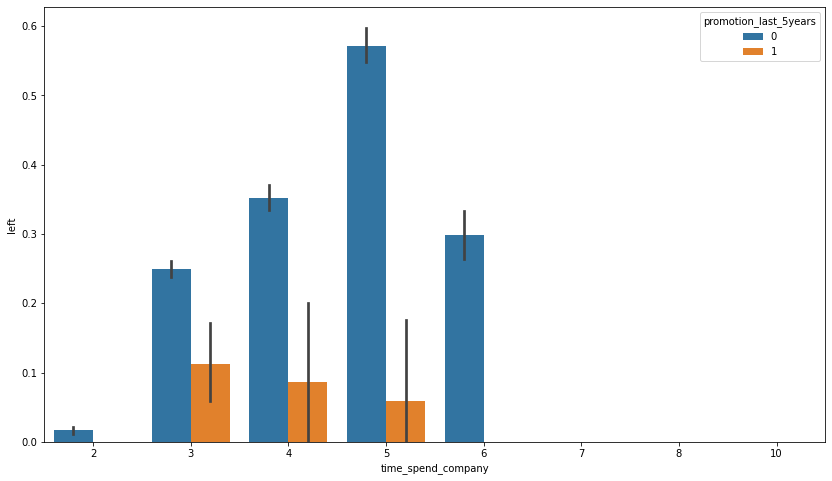

In [64]:
#time spend with promotion
plt.figure(figsize=(14,8))
sns.barplot(x='time_spend_company', y = 'left', hue = 'promotion_last_5years', data = df)

# Data Transformation

In [65]:
sal_dummy = pd.get_dummies(df['salary'])
df_new = pd.concat([df, sal_dummy], axis=1)

In [66]:
df_new.drop('salary', axis=1, inplace=True)


In [67]:
df_new.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,sales,0,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,0,0,1
3,0.72,0.87,5,223,5,0,1,0,sales,0,1,0
4,0.37,0.52,2,159,3,0,1,0,sales,0,1,0


In [68]:

X = df_new.drop(['sales', 'left', 'high'], axis=1)
y = df_new['left']

# Data Predictions

### Random Forest Classifier

In [70]:
import sklearn

In [74]:
from sklearn.model_selection import train_test_split


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [76]:
from sklearn.ensemble import RandomForestClassifier


In [77]:
rfc = RandomForestClassifier(n_estimators=100)


In [78]:
rfc.fit(X_train, y_train)


RandomForestClassifier()

In [79]:
pred = rfc.predict(X_test)


In [80]:
from sklearn.metrics import confusion_matrix, classification_report


In [81]:
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

[[3761    8]
 [  47 1134]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3769
           1       0.99      0.96      0.98      1181

    accuracy                           0.99      4950
   macro avg       0.99      0.98      0.98      4950
weighted avg       0.99      0.99      0.99      4950



In [82]:
rfc_score_train = rfc.score(X_train, y_train)
print('RFC Train Score:',rfc_score_train)
rfc_score_test = rfc.score(X_test, y_test)
print('RFC Test Score:',rfc_score_test)

RFC Train Score: 1.0
RFC Test Score: 0.9888888888888889


### K Nearest Neighbors Classifier

In [83]:
from sklearn.neighbors import KNeighborsClassifier


In [84]:
knn = KNeighborsClassifier(n_neighbors=10)


In [85]:
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=10)

In [86]:
knn_pred = knn.predict(X_test)


In [87]:
print(confusion_matrix(y_test, knn_pred))
print('\n')
print(classification_report(y_test, knn_pred))

[[3586  183]
 [ 109 1072]]


              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3769
           1       0.85      0.91      0.88      1181

    accuracy                           0.94      4950
   macro avg       0.91      0.93      0.92      4950
weighted avg       0.94      0.94      0.94      4950



In [88]:

knn_score_train = knn.score(X_train, y_train)
print('KNN Train Score:', knn_score_train)
knn_score_test = knn.score(X_test, y_test)
print('KNN Test Score:', knn_score_test)

KNN Train Score: 0.9506418549109364
KNN Test Score: 0.941010101010101


### Logistic Regression

In [89]:
from sklearn.linear_model import LogisticRegression


In [90]:
lreg = LogisticRegression()


In [91]:
lreg.fit(X_train, y_train)


LogisticRegression()

In [92]:
reg_pred = lreg.predict(X_test)


In [93]:
print(confusion_matrix(y_test, reg_pred))
print('\n')
print(classification_report(y_test, reg_pred))

[[3475  294]
 [ 779  402]]


              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3769
           1       0.58      0.34      0.43      1181

    accuracy                           0.78      4950
   macro avg       0.70      0.63      0.65      4950
weighted avg       0.76      0.78      0.76      4950



In [94]:
lreg_score_train = lreg.score(X_train, y_train)
print("Logistic Regression Train Score:", lreg_score_train)
lreg_score_test = lreg.score(X_test, y_test)
print('Logistic Regression Test Score:', lreg_score_test)

Logistic Regression Train Score: 0.7934122798288387
Logistic Regression Test Score: 0.7832323232323233
